# STEP 0. 설계
---

- 신경망 모델을 사용해서 비교해 보기
- 이름의 길이라는 특성은 전설의 포켓몬과 일반 포켓몬을 가르는 주요 특성은 아니라고 판단되어서 해당 특성에 대한 feature engineering은 시도하지 않음. (노드 학습에서는 이름의 길이를 전설의 포켓몬 내에서의 비율, 일반 포켓몬 내에서의 비율로 비교했는데, 전체 그룹에서의 비율로 비교해보면 그다지 두 그룹을 가르는 주요 특성으로 보이지 않기 때문)
- v2 에서의 새로운 시도
	- accuracy 대신 ROC AUC를 평가지표로 사용해 진행함. 
	- 혼동 행렬과 classification report를 통해 의사결정트리 결과와 비교해 봄. 
- v3 에서의 새로운 시도
	- 가중치 규제를 적용해 봄 --> 손실곡선이 계속 매끄럽게 조금씩이나마 하향하는 모습을 보이면서 오히려 과대적합 시점을 판단하기 어려워짐. 
	- 드롭아웃을 적용해 봄 --> 역시 손실곡선이 계속 매끄럽게 조금씩이나마 하향하는 모습을 보이면서 오히려 과대적합 시점을 판단하기 어려워짐. 
	- 상관관계가 높은 특성만 사용하는 '특성 선택'을 적용해 봄 --> 역시 손실곡선이 계속 매끄럽게 조금씩이나마 하향하는 모습을 보이면서 오히려 과대적합 시점을 판단하기 어려워짐. 
- v4 에서의 새로운 시도
	- 다음에도 참고할 수 있도록 군더더기 없는 코드로 재작성해 봄. 

# STEP 1. 데이터 살펴보기
---

## 구글 드라이브 연결

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

## 라이브러리 가져오기

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터셋 불러오기

In [27]:
import os

aiffel_home_dir = os.getenv('Aiffel_Home')		# 윈도우 환경에서 '사용자 환경변수'로 아예 추가해 둠. (단축키:Win+PauseBreak)
aiffel_home_dir = aiffel_home_dir.replace("\\", "/")		# 디렉토리 경로 문자열이 이스케이프 처리된 것을 일반 문자열로 변환. 
csv_file_path = aiffel_home_dir + '/Official_Course/DL_Basic/data/Pokemon.csv'
original_data = pd.read_csv(csv_file_path)

In [28]:
# 코랩에서 구글 드라이브에 있는 파일 읽어오는 경우의 코드
# # 파일 경로 : /content/drive/MyDrive/AIFFEL/Pokemon.csv
# csv_path = "/content/drive/MyDrive/AIFFEL/Pokemon.csv"
# original_data = pd.read_csv(csv_path)

In [29]:
original_data

#                   Name   Type 1  Type 2  Total  HP  Attack  Defense  \
0      1              Bulbasaur    Grass  Poison    318  45      49       49   
1      2                Ivysaur    Grass  Poison    405  60      62       63   
2      3               Venusaur    Grass  Poison    525  80      82       83   
3      3  VenusaurMega Venusaur    Grass  Poison    625  80     100      123   
4      4             Charmander     Fire     NaN    309  39      52       43   
..   ...                    ...      ...     ...    ...  ..     ...      ...   
795  719                Diancie     Rock   Fairy    600  50     100      150   
796  719    DiancieMega Diancie     Rock   Fairy    700  50     160      110   
797  720    HoopaHoopa Confined  Psychic   Ghost    600  80     110       60   
798  720     HoopaHoopa Unbound  Psychic    Dark    680  80     160       60   
799  721              Volcanion     Fire   Water    600  80     110      120   

     Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0         65       65     45           1      False  
1         80       80     60           1      False  
2        100      100     80           1      False  
3        122      120     80           1      False  
4         60       50     65           1      False  
..       ...      ...    ...         ...        ...  
795      100      150     50           6       True  
796      160      110    110           6       True  
797      150      130     70           6       True  
798      170      130     80           6       True  
799      130       90     70           6       True  

[800 rows x 13 columns]

In [30]:
# 기본 정보 확인
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [31]:
# 기본 통계 정보 확인
original_data.describe()

#      Total          HP      Attack     Defense     Sp. Atk  \
count  800.000000  800.00000  800.000000  800.000000  800.000000  800.000000   
mean   362.813750  435.10250   69.258750   79.001250   73.842500   72.820000   
std    208.343798  119.96304   25.534669   32.457366   31.183501   32.722294   
min      1.000000  180.00000    1.000000    5.000000    5.000000   10.000000   
25%    184.750000  330.00000   50.000000   55.000000   50.000000   49.750000   
50%    364.500000  450.00000   65.000000   75.000000   70.000000   65.000000   
75%    539.250000  515.00000   80.000000  100.000000   90.000000   95.000000   
max    721.000000  780.00000  255.000000  190.000000  230.000000  194.000000   

          Sp. Def       Speed  Generation  
count  800.000000  800.000000   800.00000  
mean    71.902500   68.277500     3.32375  
std     27.828916   29.060474     1.66129  
min     20.000000    5.000000     1.00000  
25%     50.000000   45.000000     2.00000  
50%     70.000000   65.000000     3.00000  
75%     90.000000   90.000000     5.00000  
max    230.000000  180.000000     6.00000

## 특성간 상관관계 분석하기

In [32]:
# 숫자 특성만 추출한 데이터프레임
corr_df = original_data.drop(['Name', 'Type 1', 'Type 2'], axis=1)

# 상관행렬 계산
corr_matrix = corr_df.corr()

# 상관행렬 출력
print(corr_matrix)

                   #     Total        HP    Attack   Defense   Sp. Atk  \
#           1.000000  0.119813  0.097614  0.102298  0.094786  0.088759   
Total       0.119813  1.000000  0.618748  0.736211  0.612787  0.747250   
HP          0.097614  0.618748  1.000000  0.422386  0.239622  0.362380   
Attack      0.102298  0.736211  0.422386  1.000000  0.438687  0.396362   
Defense     0.094786  0.612787  0.239622  0.438687  1.000000  0.223549   
Sp. Atk     0.088759  0.747250  0.362380  0.396362  0.223549  1.000000   
Sp. Def     0.085817  0.717609  0.378718  0.263990  0.510747  0.506121   
Speed       0.010733  0.575943  0.175952  0.381240  0.015227  0.473018   
Generation  0.982516  0.048384  0.058683  0.051451  0.042419  0.036437   
Legendary   0.153396  0.501758  0.273620  0.345408  0.246377  0.448907   

             Sp. Def     Speed  Generation  Legendary  
#           0.085817  0.010733    0.982516   0.153396  
Total       0.717609  0.575943    0.048384   0.501758  
HP          0.378

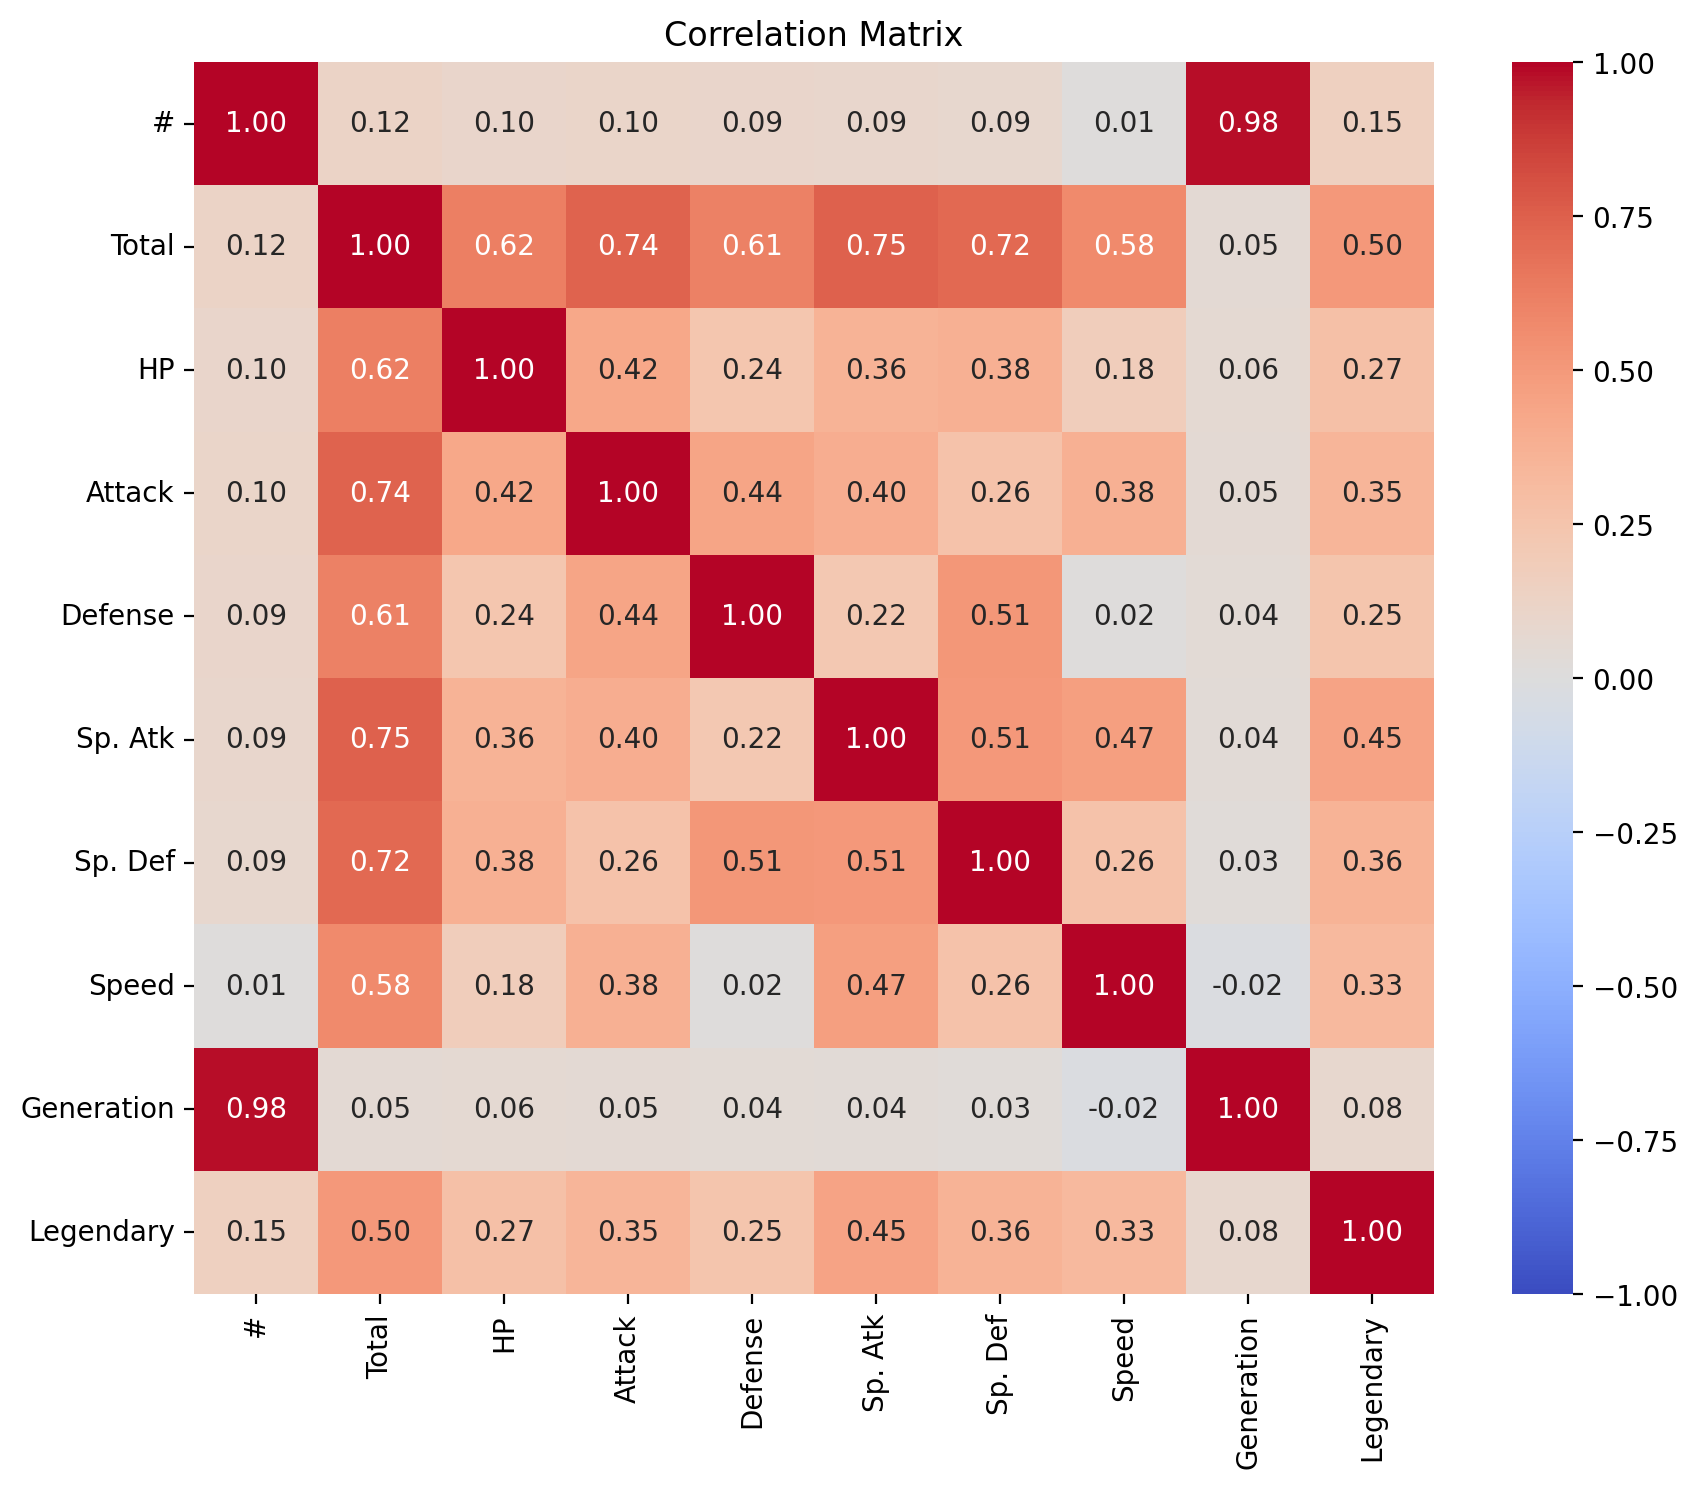

In [33]:
# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

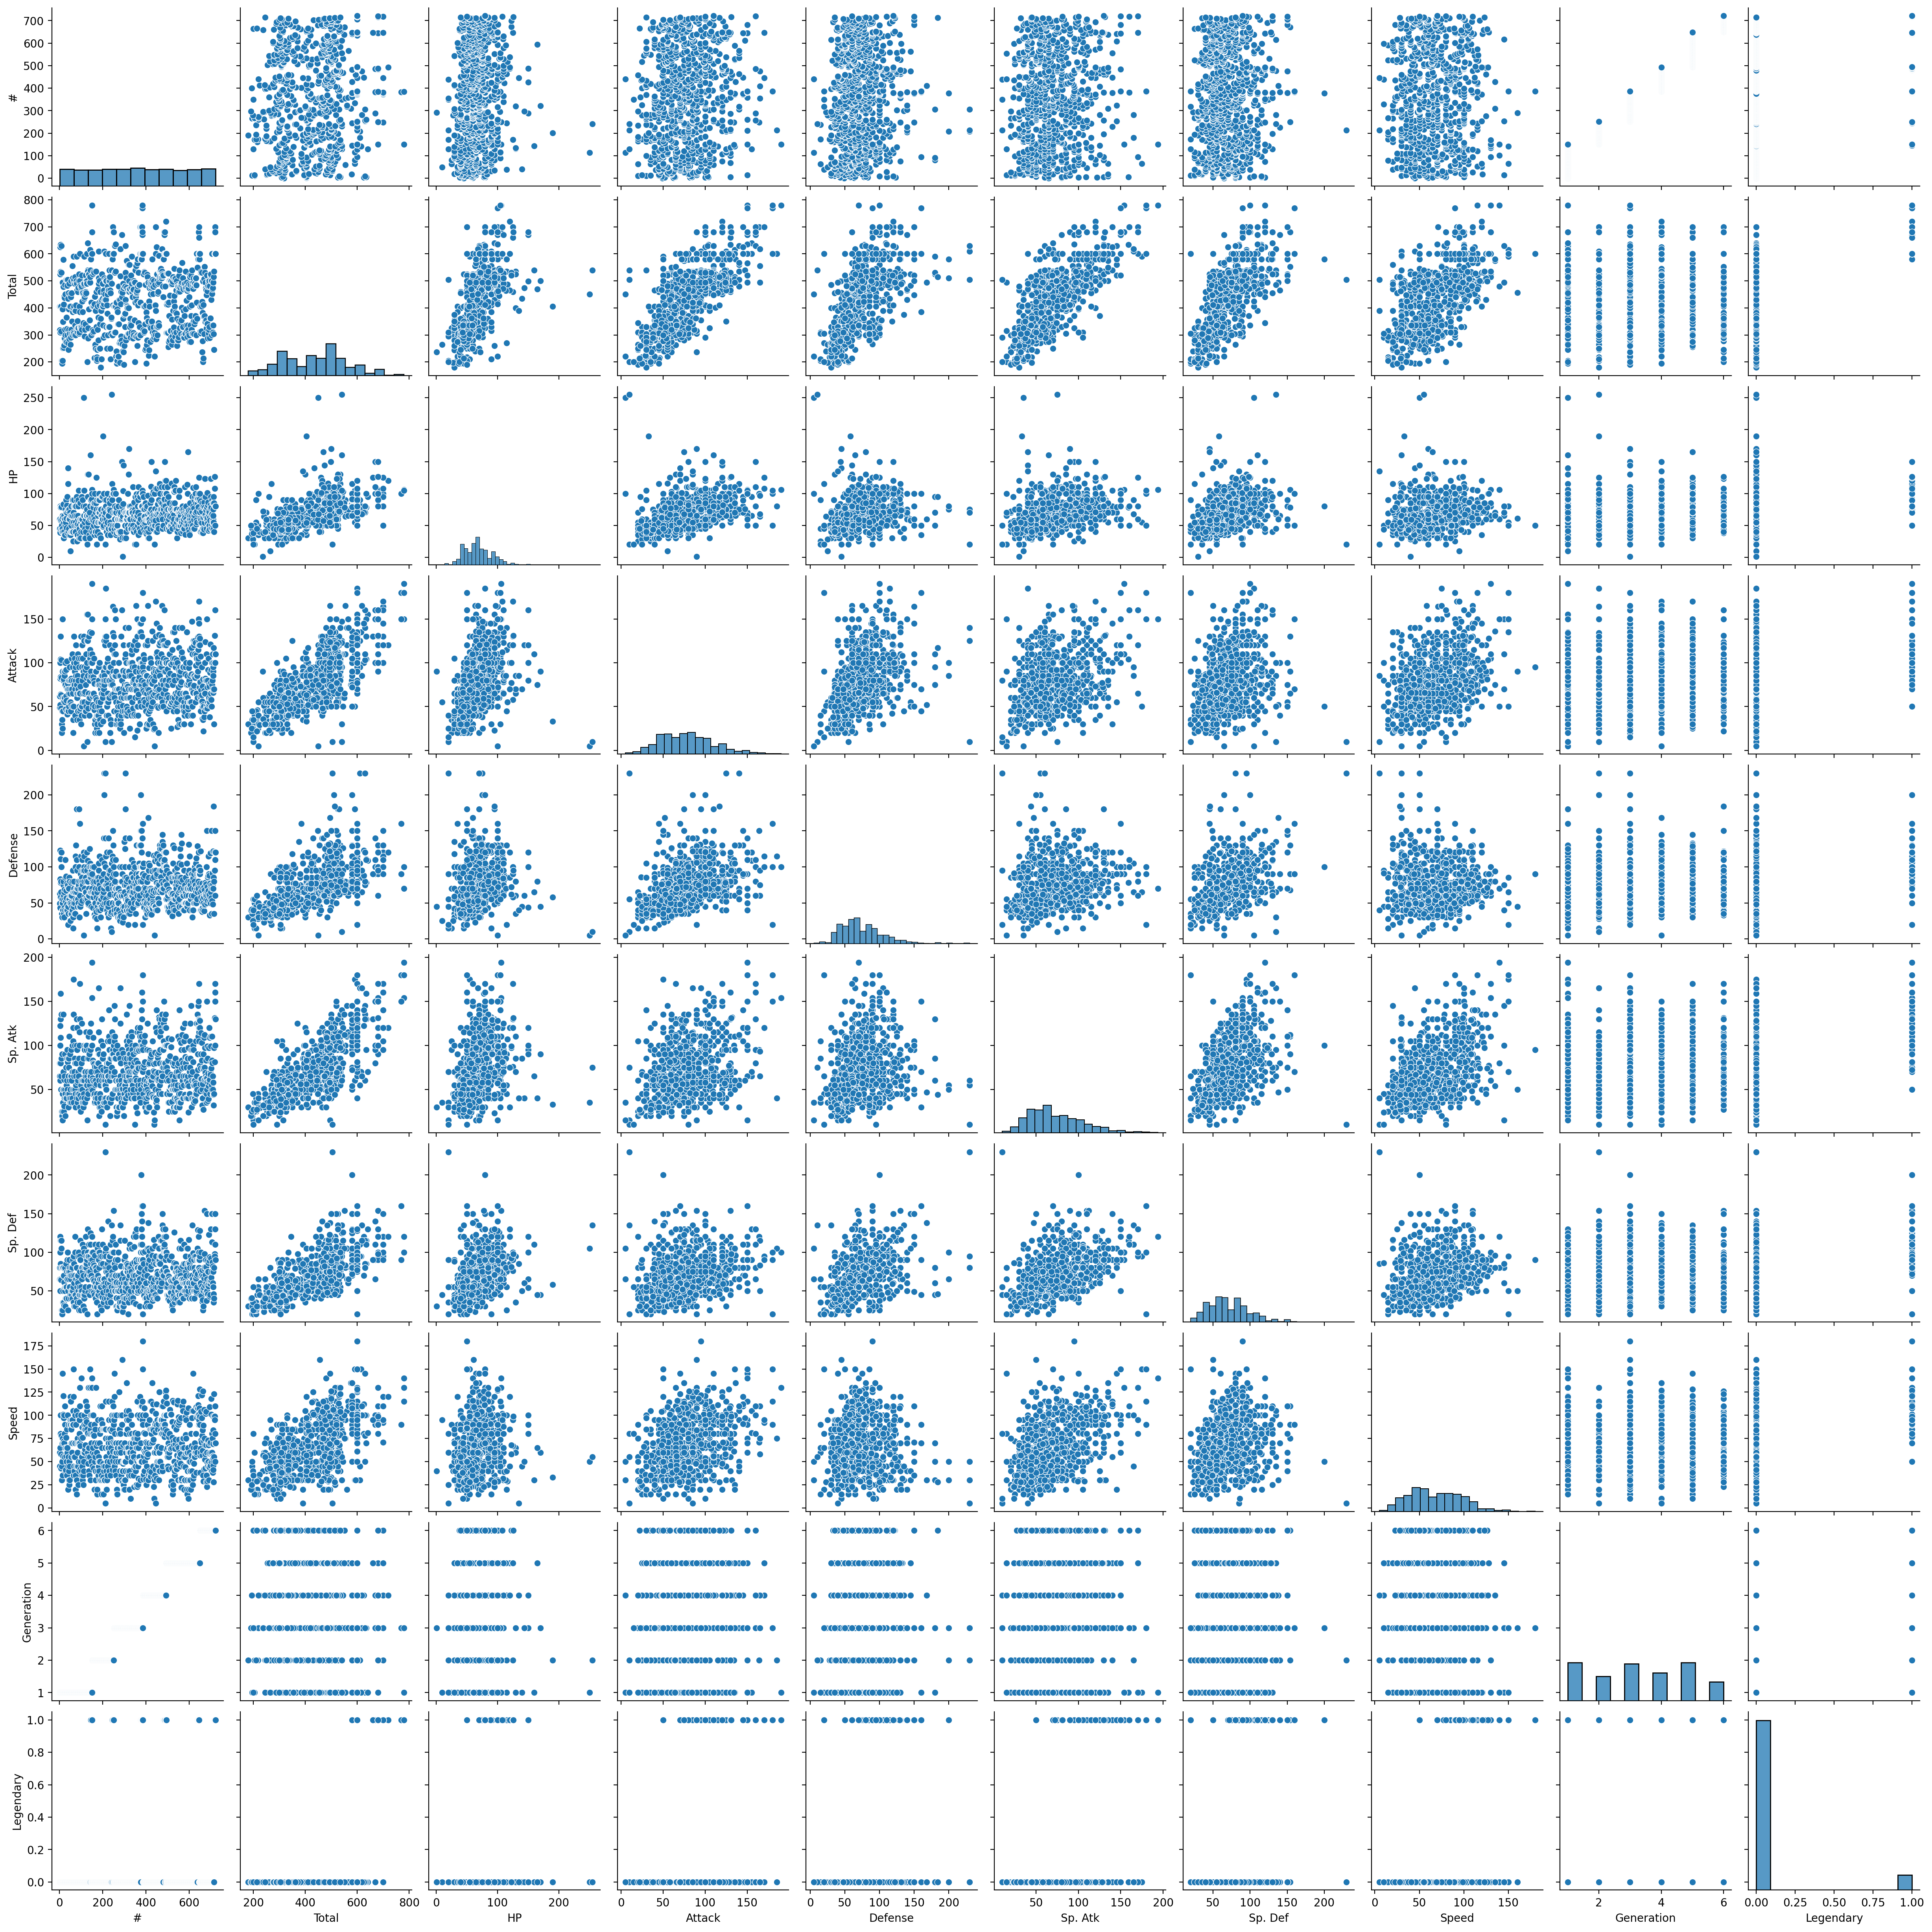

In [34]:
# 페어플롯 시각화
sns.pairplot(corr_df)
plt.show()

## 범주형 특성과 숫자 특성 구분하기

In [35]:
original_data.keys()

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [36]:
# 숫자형 특성과 범주형 특성, 타겟 특성 구분하기
numeric_features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
categorical_features = ['Type 1', 'Type 2', 'Generation']
target_features = ['Legendary']

In [37]:
original_data[numeric_features]

Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
0      318  45      49       49       65       65     45
1      405  60      62       63       80       80     60
2      525  80      82       83      100      100     80
3      625  80     100      123      122      120     80
4      309  39      52       43       60       50     65
..     ...  ..     ...      ...      ...      ...    ...
795    600  50     100      150      100      150     50
796    700  50     160      110      160      110    110
797    600  80     110       60      150      130     70
798    680  80     160       60      170      130     80
799    600  80     110      120      130       90     70

[800 rows x 7 columns]

In [38]:
original_data[categorical_features]

Type 1  Type 2  Generation
0      Grass  Poison           1
1      Grass  Poison           1
2      Grass  Poison           1
3      Grass  Poison           1
4       Fire     NaN           1
..       ...     ...         ...
795     Rock   Fairy           6
796     Rock   Fairy           6
797  Psychic   Ghost           6
798  Psychic    Dark           6
799     Fire   Water           6

[800 rows x 3 columns]

In [39]:
original_data[target_features]

Legendary
0        False
1        False
2        False
3        False
4        False
..         ...
795       True
796       True
797       True
798       True
799       True

[800 rows x 1 columns]

## 원본 데이터 복사하기

In [40]:
pokemon = original_data.copy()
print(pokemon.shape)
pokemon.head()

(800, 13)


#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

In [41]:
# 전설의 포켓몬 데이터셋
legendary = pokemon[pokemon["Legendary"] == True].reset_index(drop=True)
print(legendary.shape)
legendary.head()

(65, 13)


#                 Name    Type 1    Type 2  Total   HP  Attack  Defense  \
0  144             Articuno       Ice    Flying    580   90      85      100   
1  145               Zapdos  Electric    Flying    580   90      90       85   
2  146              Moltres      Fire    Flying    580   90     100       90   
3  150               Mewtwo   Psychic       NaN    680  106     110       90   
4  150  MewtwoMega Mewtwo X   Psychic  Fighting    780  106     190      100   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       95      125     85           1       True  
1      125       90    100           1       True  
2      125       85     90           1       True  
3      154       90    130           1       True  
4      154      100    130           1       True

In [42]:
# 일반 포켓몬의 데이터셋
ordinary = pokemon[pokemon["Legendary"] == False].reset_index(drop=True)
print(ordinary.shape)
ordinary.head()

(735, 13)


#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

# STEP 2. 데이터 전처리
---

## 중복 데이터 여부 확인하기

In [43]:
pokemon.duplicated().sum()

0

## 이상치 제거

In [44]:
# 결측치 확인
pokemon.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [45]:
# 결측치에 대한 평균값 계산
pokemon.isnull().mean()

#             0.0000
Name          0.0000
Type 1        0.0000
Type 2        0.4825
Total         0.0000
HP            0.0000
Attack        0.0000
Defense       0.0000
Sp. Atk       0.0000
Sp. Def       0.0000
Speed         0.0000
Generation    0.0000
Legendary     0.0000
dtype: float64

In [46]:
# Type 2 값이 NaN인 행 인덱스만 별도로 저장
type2_na_index = pokemon[pokemon['Type 2'].isnull()].index
type2_na_index

Index([  4,   5,   9,  10,  11,  12,  13,  14,  24,  25,
       ...
       755, 762, 763, 770, 774, 775, 776, 788, 789, 792],
      dtype='int64', length=386)

In [47]:
pokemon.loc[type2_na_index]

#        Name  Type 1 Type 2  Total   HP  Attack  Defense  Sp. Atk  \
4      4  Charmander    Fire    NaN    309   39      52       43       60   
5      5  Charmeleon    Fire    NaN    405   58      64       58       80   
9      7    Squirtle   Water    NaN    314   44      48       65       50   
10     8   Wartortle   Water    NaN    405   59      63       80       65   
11     9   Blastoise   Water    NaN    530   79      83      100       85   
..   ...         ...     ...    ...    ...  ...     ...      ...      ...   
775  705     Sliggoo  Dragon    NaN    452   68      75       53       83   
776  706      Goodra  Dragon    NaN    600   90     100       70      110   
788  712    Bergmite     Ice    NaN    304   55      69       85       32   
789  713     Avalugg     Ice    NaN    514   95     117      184       44   
792  716     Xerneas   Fairy    NaN    680  126     131       95      131   

     Sp. Def  Speed  Generation  Legendary  
4         50     65           1      False  
5         65     80           1      False  
9         64     43           1      False  
10        80     58           1      False  
11       105     78           1      False  
..       ...    ...         ...        ...  
775      113     60           6      False  
776      150     80           6      False  
788       35     28           6      False  
789       46     28           6      False  
792       98     99           6       True  

[386 rows x 13 columns]

In [48]:
# Type 2 컬럼의 결측치 값을 'None'으로 대체하기(모델이 'None' 클래스로 학습할 수 있도록!!)
pokemon['Type 2'] = pokemon['Type 2'].fillna('None')

In [49]:
# 결측치가 남아있는지 재확인
pokemon.isnull().sum()

#             0
Name          0
Type 1        0
Type 2        0
Total         0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64

In [50]:
# 앞에서 저장해 두었던 변수를 이용해 해당 행들이 잘 채워졌는지 확인하기 (loc 사용)
pokemon.loc[type2_na_index]

#        Name  Type 1 Type 2  Total   HP  Attack  Defense  Sp. Atk  \
4      4  Charmander    Fire   None    309   39      52       43       60   
5      5  Charmeleon    Fire   None    405   58      64       58       80   
9      7    Squirtle   Water   None    314   44      48       65       50   
10     8   Wartortle   Water   None    405   59      63       80       65   
11     9   Blastoise   Water   None    530   79      83      100       85   
..   ...         ...     ...    ...    ...  ...     ...      ...      ...   
775  705     Sliggoo  Dragon   None    452   68      75       53       83   
776  706      Goodra  Dragon   None    600   90     100       70      110   
788  712    Bergmite     Ice   None    304   55      69       85       32   
789  713     Avalugg     Ice   None    514   95     117      184       44   
792  716     Xerneas   Fairy   None    680  126     131       95      131   

     Sp. Def  Speed  Generation  Legendary  
4         50     65           1      False  
5         65     80           1      False  
9         64     43           1      False  
10        80     58           1      False  
11       105     78           1      False  
..       ...    ...         ...        ...  
775      113     60           6      False  
776      150     80           6      False  
788       35     28           6      False  
789       46     28           6      False  
792       98     99           6       True  

[386 rows x 13 columns]

## feature 가공

In [459]:
# 범주형 데이터인 Generation 컬럼에 대해서도 feature 가공
generations = list(set(pokemon["Generation"]))
print(len(generations))
print(generations)

6
[1, 2, 3, 4, 5, 6]


In [460]:
# Generation 컬럼 값을 원-핫 인코딩으로 변환
for g in generations:
    pokemon[g] = (pokemon["Generation"] == g)

pokemon[[["Type 1", "Type 2"] + generations][0]].head()

Type 1  Type 2     1      2      3      4      5      6
0  Grass  Poison  True  False  False  False  False  False
1  Grass  Poison  True  False  False  False  False  False
2  Grass  Poison  True  False  False  False  False  False
3  Grass  Poison  True  False  False  False  False  False
4   Fire    None  True  False  False  False  False  False

In [461]:
# 컬럼 이름 변경하기 (기본축이 행이므로 axis=1 추가해야 함)
pokemon = pokemon.rename({1: 'Gen1', 2: 'Gen2', 3: 'Gen3', 4: 'Gen4', 5: 'Gen5', 6: 'Gen6'}, axis=1)

In [462]:
pokemon.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire    None    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  Gen1   Gen2   Gen3   Gen4  \
0       65       65     45           1      False  True  False  False  False   
1       80       80     60           1      False  True  False  False  False   
2      100      100     80           1      False  True  False  False  False   
3      122      120     80           1      False  True  False  False  False   
4       60       50     65           1      False  True  False  False  False   

    Gen5   Gen6  
0  False  False  
1  False  False  
2  False  False  
3  False  False  
4  False  False

In [463]:
# 세대별 개수 확인
pokemon[['Gen1', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6']].sum()

Gen1    166
Gen2    106
Gen3    160
Gen4    121
Gen5    165
Gen6     82
dtype: int64

In [464]:
# 포켓몬 Type 2 데이터를 중복 없이 types에 저장
# Type 2에 'None' 특성이 추가되었기 때문에 'Type 1' 이 아니라 'Type 2' 기준으로 추출해야 함.
types = list(set(pokemon["Type 2"]))
print(len(types))
print(types)

19
['Fairy', 'Dark', 'Electric', 'Normal', 'Ice', 'Water', 'Ground', 'Dragon', 'Rock', 'Fire', 'Grass', 'None', 'Bug', 'Ghost', 'Fighting', 'Poison', 'Psychic', 'Flying', 'Steel']


In [465]:
# 'Type 1', 'Type 2' 값을 멀티-핫 인코딩으로 변환
for t in types:
    pokemon[t] = (pokemon["Type 1"] == t) | (pokemon["Type 2"] == t)

pokemon[[["Type 1", "Type 2"] + types][0]].head()

Type 1  Type 2  Fairy   Dark  Electric  Normal    Ice  Water  Ground  \
0  Grass  Poison  False  False     False   False  False  False   False   
1  Grass  Poison  False  False     False   False  False  False   False   
2  Grass  Poison  False  False     False   False  False  False   False   
3  Grass  Poison  False  False     False   False  False  False   False   
4   Fire    None  False  False     False   False  False  False   False   

   Dragon  ...   Fire  Grass   None    Bug  Ghost  Fighting  Poison  Psychic  \
0   False  ...  False   True  False  False  False     False    True    False   
1   False  ...  False   True  False  False  False     False    True    False   
2   False  ...  False   True  False  False  False     False    True    False   
3   False  ...  False   True  False  False  False     False    True    False   
4   False  ...   True  False   True  False  False     False   False    False   

   Flying  Steel  
0   False  False  
1   False  False  
2   False  False  
3   False  False  
4   False  False  

[5 rows x 21 columns]

In [466]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 38 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      800 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
 13  Gen1        800 non-null    bool  
 14  Gen2        800 non-null    bool  
 15  Gen3        800 non-null    bool  
 16  Gen4        800 non-null    bool  
 17  Gen5        800 non-null    bool  
 18  Gen6        800 non-null    bool  
 19  Fairy       800 non-null    bool  
 20  Dark      

# STEP 3. 모델링과 하이퍼 파라미터 튜닝
---

## 베이스라인 모델 훈련 및 검증

In [467]:
# feature 가공 처리하지 않은 특성 모음
# [시도] 히트맵을 통해 일정 비율 이상(0.3 이상)의 상관관계를 가지는 특성만 추출함. --> 오히려 과대적합 시점이 거의 나타나지 않음. 
# features = ['Total', 'Attack', 'Sp. Atk', 'Sp. Def', 'Speed']
# features = ['Total', 'Sp. Atk']
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
target = 'Legendary'

In [468]:
# 원본 데이터로부터 추출
X = original_data[features]
print(X.shape)
X.head()

(800, 8)


Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation
0    318  45      49       49       65       65     45           1
1    405  60      62       63       80       80     60           1
2    525  80      82       83      100      100     80           1
3    625  80     100      123      122      120     80           1
4    309  39      52       43       60       50     65           1

In [469]:
# 원본 데이터로부터 추출
y = original_data[target]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

In [470]:
# 훈련 데이터셋과 테스트 데이터셋 분리
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=15)

print(train_data.shape, train_targets.shape)
print(test_data.shape, test_targets.shape)

(640, 8) (640,)
(160, 8) (160,)


### 데이터 정규화하기

In [471]:
# 정규화 : 평균을 빼고 표준편차로 나누기 -> 평균이 0, 표준편차가 1인 정규분포로 만들어짐.
# [중요] 각 특성별로 정규화해야 함.
# axis=0 의 의미 : 첫번째 축(즉, 샘플축)의 개수를 사용해 평균과 표준편차를 계산한다는 의미임. 즉, 샘플 개수로 나누겠다는 의미.
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# [중요] 테스트 데이터셋에 대해서 정규화 할 때에도 앞에서 훈련 데이터셋에서 계산한 평균값과 표준편차값을 그대로 재사용해서 정규화해야 함!
test_data -= mean
test_data /= std

In [472]:
train_data

Total        HP    Attack   Defense   Sp. Atk   Sp. Def     Speed  \
300 -0.051796 -0.357560  0.182272 -0.445624 -0.692950 -0.795553  1.922531   
351  0.537902  3.886616  0.337067 -0.931539  0.515546 -0.972921 -0.295118   
193 -1.315435 -0.550477 -1.210888 -1.093511 -0.239764 -0.972921 -1.148060   
794  1.380328  1.494444  0.646658  1.530429  0.243635  0.800763  0.899001   
798  2.054269  0.414109  2.504205 -0.445624  2.932538  2.042342  0.387236   
..        ...       ...       ...       ...       ...       ...       ...   
156  1.211843  0.799943  0.182272  0.850148  0.666608  1.864974  0.557824   
384  0.032447 -0.357560  0.337067 -0.121681 -0.390826  1.687606 -0.977471   
645  0.832751  0.066858  0.491863  0.364234  1.119794  0.800763  0.353118   
757  0.386266  0.645609  0.398986  0.461417 -0.149126  0.091289  0.148412   
456  0.495781 -0.357560 -0.839379  3.052962 -0.783587  2.326132 -1.318648   

     Generation  
300   -0.169252  
351   -0.169252  
193   -0.774399  
794    1.646188  
798    1.646188  
..          ...  
156   -1.379545  
384   -0.169252  
645    1.041041  
757    1.646188  
456    0.435895  

[640 rows x 8 columns]

In [473]:
test_data

Total        HP    Attack   Defense   Sp. Atk   Sp. Def     Speed  \
270  2.054269  1.417277  1.575432  0.526205  1.119794  2.893711  0.728412   
475  0.369417 -0.164643 -0.096360  0.331839 -0.572100  0.836237  1.240178   
158  1.211843  0.799943  0.646658  0.526205  1.572980  0.446026  0.728412   
247  0.537902  0.221191  0.337067 -0.769568  1.119794  0.268658  0.899001   
452  0.664266 -0.357560 -0.282115 -0.283653  1.572980  1.155500  0.728412   
..        ...       ...       ...       ...       ...       ...       ...   
719 -0.262403 -0.318976 -0.034442  0.688177 -0.511675 -0.511763 -0.397471   
548  1.380328  1.185777  0.646658  0.850148  0.817670  0.978132  1.069589   
618 -0.936344 -0.743394 -0.436910  0.364234 -1.146136 -1.327658 -0.465706   
785  0.487357 -0.550477  0.182272  1.562824 -0.451250  0.091289  1.035471   
41   0.394690  0.992860 -0.282115 -0.024498  0.666608  0.623395 -0.295118   

     Generation  
270   -0.774399  
475    0.435895  
158   -1.379545  
247   -0.774399  
452    0.435895  
..          ...  
719    1.646188  
548    0.435895  
618    1.041041  
785    1.646188  
41    -1.379545  

[160 rows x 8 columns]

In [474]:
# test_targets(Series 객체)에서 값이 True인 개수 확인
test_targets.sum()

13

In [475]:
# targets 데이터의 True/False 값을 1/0 으로 변환
train_targets = train_targets.replace({True:1, False:0})
test_targets = test_targets.replace({True:1, False:0})
train_targets

C:\Users\freen\AppData\Local\Temp\ipykernel_20168\1555252642.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_targets = train_targets.replace({True:1, False:0})
C:\Users\freen\AppData\Local\Temp\ipykernel_20168\1555252642.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_targets = test_targets.replace({True:1, False:0})


300    0
351    0
193    0
794    1
798    1
      ..
156    1
384    0
645    0
757    0
456    0
Name: Legendary, Length: 640, dtype: int64

In [476]:
# test_targets(Series 객체)에서 값이 True인 개수 확인
test_targets.sum()

13

In [477]:
# Numpy 배열 형태로 변환
train_data = np.array(train_data)
train_targets = np.array(train_targets)
test_data = np.array(test_data)
test_targets = np.array(test_targets)

In [478]:
train_data

array([[-0.05179605, -0.35755976,  0.18227177, ..., -0.79555301,
         1.92253107, -0.16925197],
       [ 0.53790227,  3.88661609,  0.33706733, ..., -0.97292148,
        -0.2951179 , -0.16925197],
       [-1.31543528, -0.55047684, -1.21088826, ..., -0.97292148,
        -1.14805981, -0.7743987 ],
       ...,
       [ 0.83275142,  0.06685783,  0.49186289, ...,  0.80076321,
         0.35311795,  1.04104147],
       [ 0.38626556,  0.64560908,  0.39898555, ...,  0.09128933,
         0.14841189,  1.64618819],
       [ 0.49578096, -0.35755976, -0.83937892, ...,  2.32613204,
        -1.31864819,  0.43589475]])

In [479]:
train_targets

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [480]:
test_data

array([[ 2.05426935,  1.41727742,  1.5754318 , ...,  2.89371114,
         0.72841239, -0.7743987 ],
       [ 0.36941703, -0.16464267, -0.09636024, ...,  0.8362369 ,
         1.24017754,  0.43589475],
       [ 1.21184319,  0.79994275,  0.64665845, ...,  0.44602627,
         0.72841239, -1.37954542],
       ...,
       [-0.93634351, -0.74339393, -0.43691046, ..., -1.32765842,
        -0.46570628,  1.04104147],
       [ 0.4873567 , -0.55047684,  0.18227177, ...,  0.09128933,
         1.03547148,  1.64618819],
       [ 0.39468982,  0.99285983, -0.28211491, ...,  0.62339474,
        -0.2951179 , -1.37954542]])

In [481]:
test_targets

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [482]:
# test_targets 배열에서 값이 1인 항목의 개수 계산하기
np.sum(test_targets == 1)

13

### K-겹 교차 검증 진행

In [483]:
# K-겹 교차 검증에 사용할 기본 모델 정의, 컴파일
# [시도] 가중치 규제 또는 드롭다운을 추가함 --> 훈련시켜보니 너무 내끄러워지면서 오히려 과적합 시점이 거의 드러나지 않음. 
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras import regularizers

def build_model():
    model = keras.Sequential([
        # layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
        layers.Dense(16, activation="relu"),
        # layers.Dropout(0.2),
        # layers.Dense(8, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
        layers.Dense(8, activation="relu"),
        # layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    # model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["AUC"])
    return model

In [484]:
# K-겹 교차 검증 진행
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100

all_loss_histories = []
all_val_loss_histories = []
# all_acc_histories = []
all_auc_histories = []
all_val_auc_histories = []

for i in range(k):
    print(f"#{i}번째 폴드 처리중")

    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    # [확인용] 지정한 평가지표에 따른 History 객체가 포함하고 있는 key 이름 출력
    print(history.history.keys())

    # loss_history = history.history["val_loss"]
    # acc_history = history.history["val_accuracy"]
    # all_loss_histories.append(loss_history)
    # all_acc_histories.append(acc_history)

    loss_history = history.history["loss"]
    val_loss_history = history.history["val_loss"]
    auc_history = history.history["AUC"]
    val_auc_history = history.history["val_AUC"]

    all_loss_histories.append(loss_history)
    all_val_loss_histories.append(val_loss_history)
    all_auc_histories.append(auc_history)
    all_val_auc_histories.append(val_auc_history)      

#0번째 폴드 처리중
dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])
#1번째 폴드 처리중
dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])
#2번째 폴드 처리중
dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])
#3번째 폴드 처리중
dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


In [485]:
# 정확도 평균값 계산하기
# average_acc_history = [
#     np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]

# AUC 평균값 계산하기
average_auc_history = [
    np.mean([x[i] for x in all_auc_histories]) for i in range(num_epochs)]

average_val_auc_history = [
    np.mean([x[i] for x in all_val_auc_histories]) for i in range(num_epochs)]

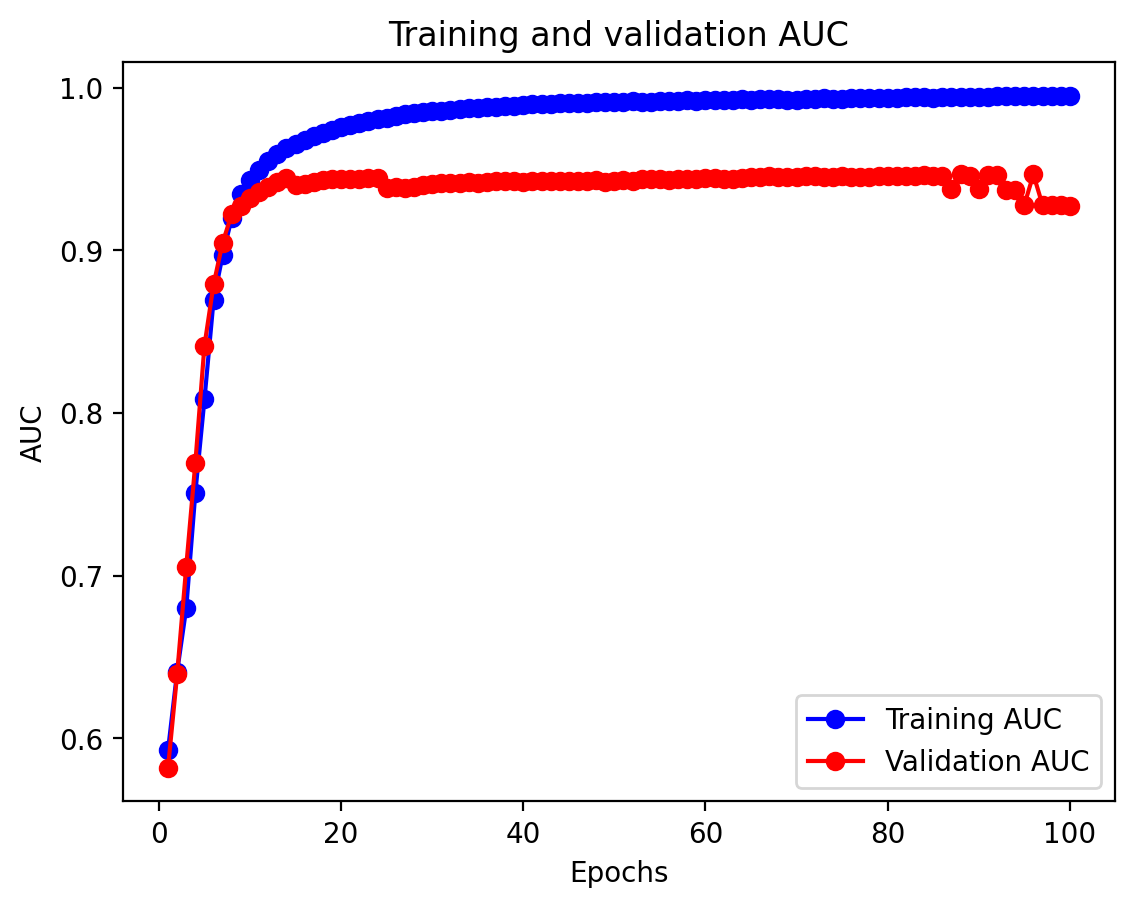

In [486]:
# AUC 값 그래프로 표시하기
epochs = range(1, len(average_auc_history) + 1)
plt.plot(epochs, average_auc_history, "bo-", label="Training AUC")
plt.plot(epochs, average_val_auc_history, "ro-", label="Validation AUC")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

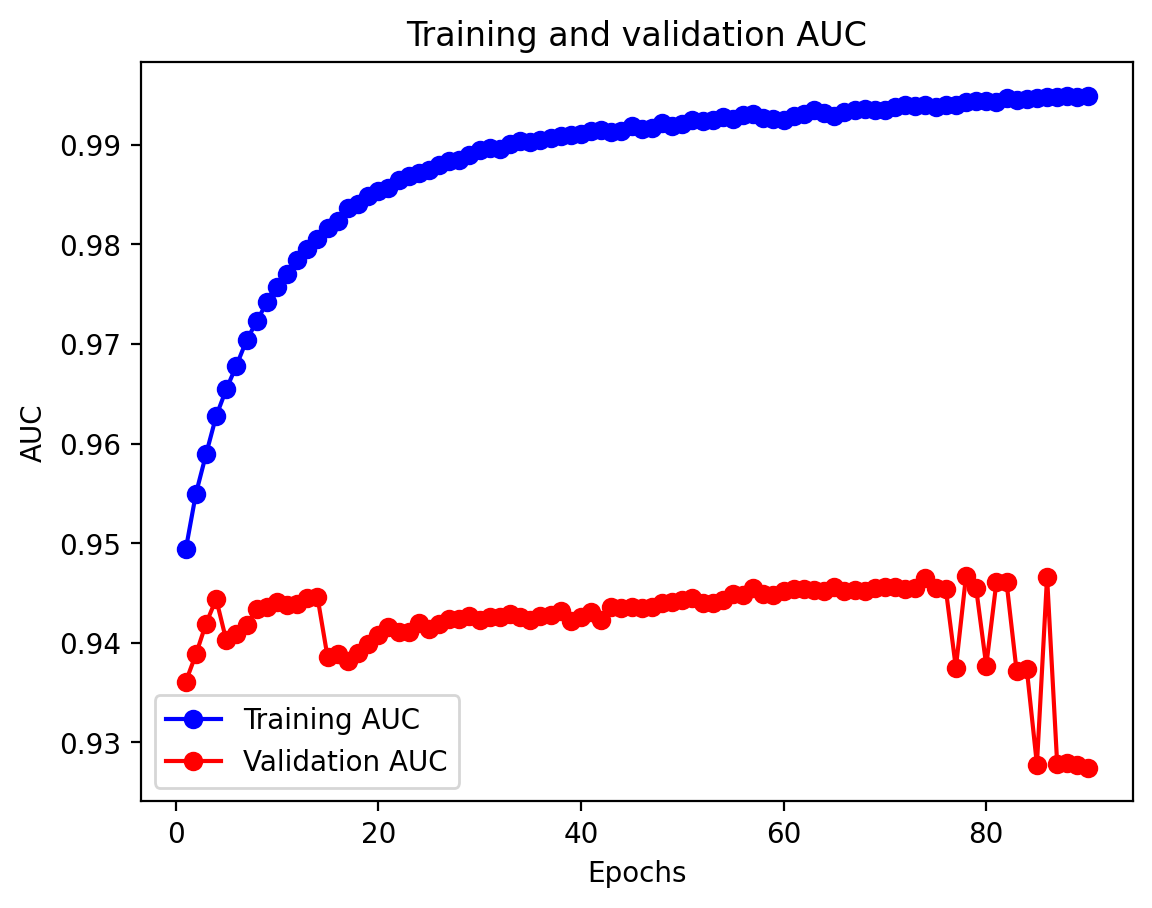

In [487]:
truncated_auc_history = average_auc_history[10:]
truncated_val_auc_history = average_val_auc_history[10:]
epochs = range(1, len(truncated_auc_history) + 1)

plt.plot(epochs, truncated_auc_history, "bo-", label="Training AUC")
plt.plot(epochs, truncated_val_auc_history, "ro-", label="Validation AUC")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [488]:
# 손실값 평균값 계산하기
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]

average_val_loss_history = [
    np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]

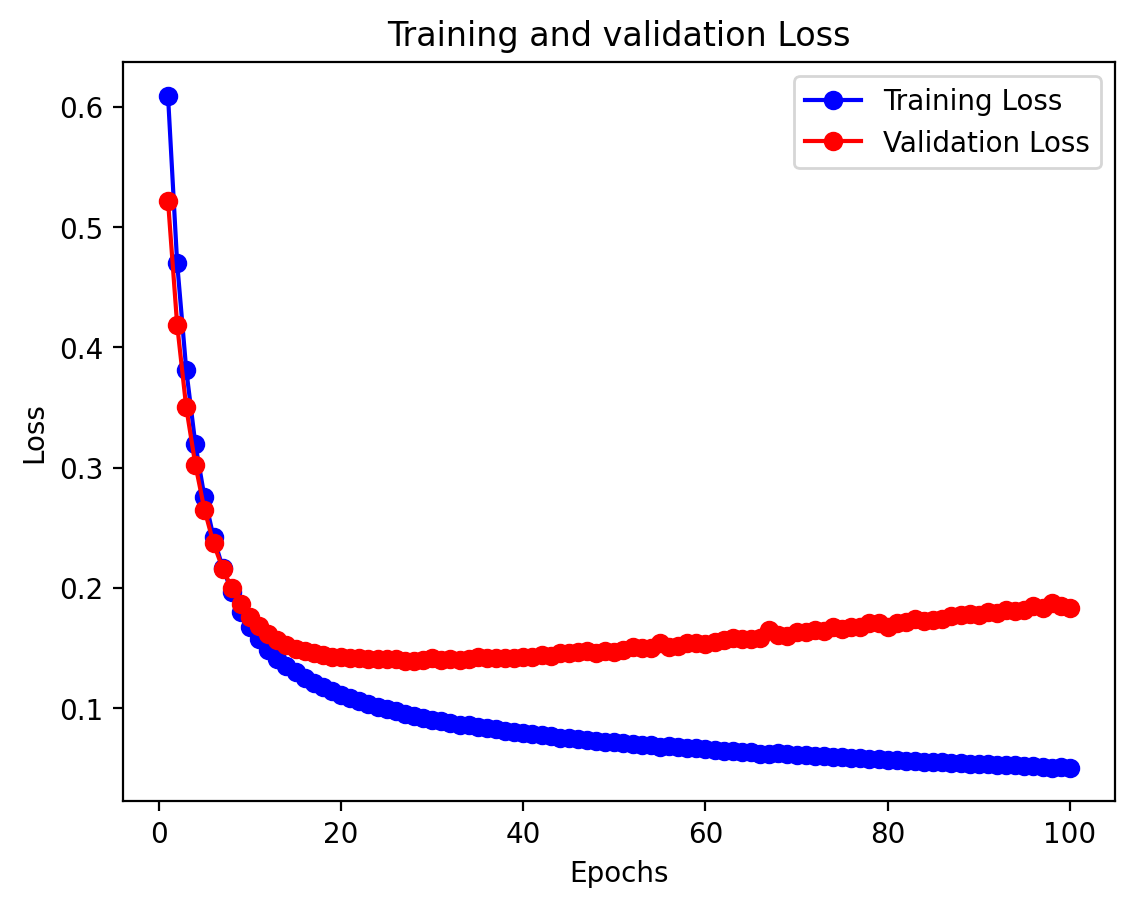

In [489]:
# loss 값 그래프로 표시하기
epochs = range(1, len(average_loss_history) + 1)
plt.plot(epochs, average_loss_history, "bo-", label="Training Loss")
plt.plot(epochs, average_val_loss_history, "ro-", label="Validation Loss")
plt.title("Training and validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

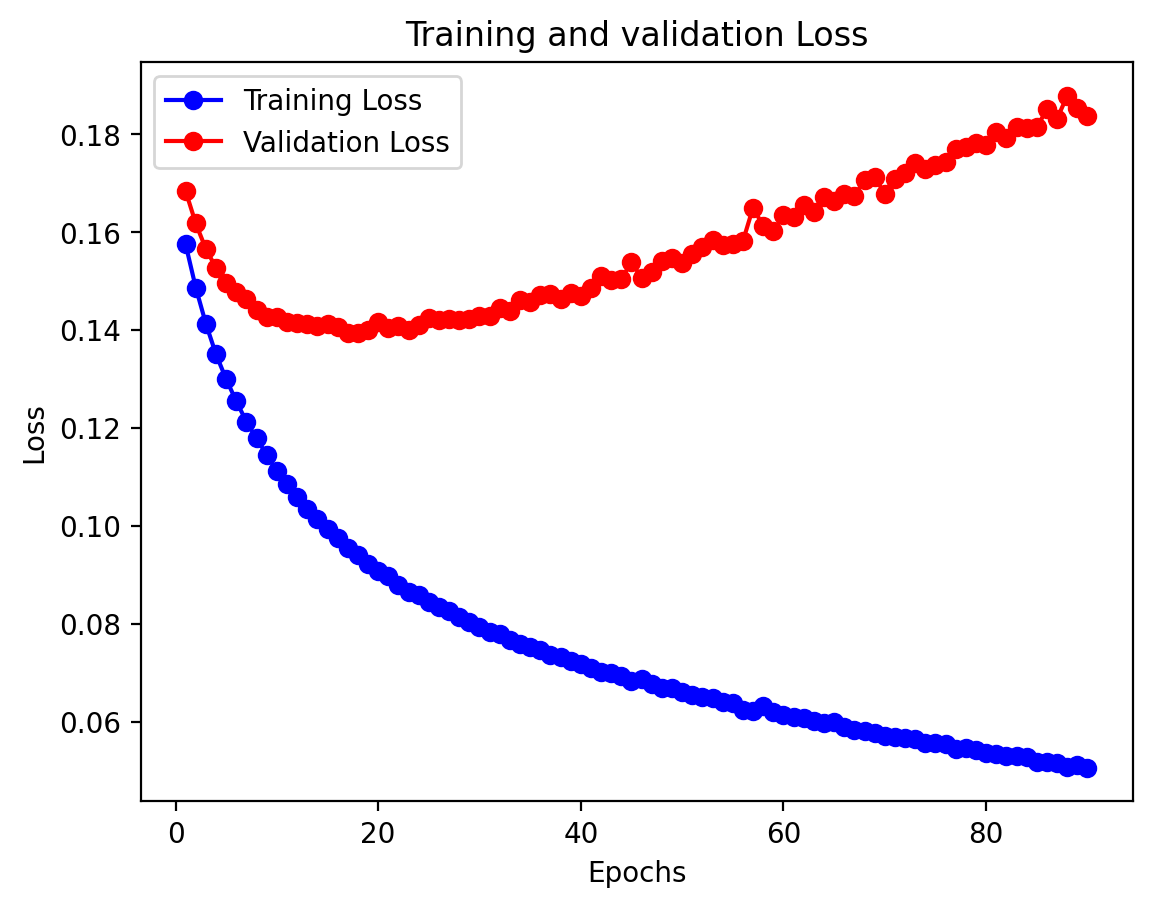

In [490]:
truncated_loss_history = average_loss_history[10:]
truncated_val_loss_history = average_val_loss_history[10:]
epochs = range(1, len(truncated_loss_history) + 1)

plt.plot(epochs, truncated_loss_history, "bo-", label="Training Loss")
plt.plot(epochs, truncated_val_loss_history, "ro-", label="Validation Loss")
plt.title("Training and validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [491]:
pd.Series(average_val_auc_history)[:60]

0     0.581882
1     0.639352
2     0.705603
3     0.769441
4     0.841456
5     0.879007
6     0.904749
7     0.922364
8     0.927304
9     0.932348
10    0.936100
11    0.938839
12    0.941931
13    0.944396
14    0.940238
15    0.940862
16    0.941835
17    0.943395
18    0.943553
19    0.944093
20    0.943781
21    0.943932
22    0.944511
23    0.944587
24    0.938536
25    0.938920
26    0.938204
27    0.939015
28    0.939909
29    0.940747
30    0.941563
31    0.941134
32    0.941086
33    0.941971
34    0.941417
35    0.941913
36    0.942385
37    0.942358
38    0.942672
39    0.942245
40    0.942607
41    0.942639
42    0.942866
43    0.942569
44    0.942299
45    0.942727
46    0.942764
47    0.943222
48    0.942194
49    0.942635
50    0.943103
51    0.942290
52    0.943616
53    0.943518
54    0.943585
55    0.943463
56    0.943561
57    0.944009
58    0.944091
59    0.944347
dtype: float64

In [492]:
pd.Series(average_val_loss_history)[:60]

0     0.521910
1     0.419054
2     0.350099
3     0.302651
4     0.265198
5     0.237143
6     0.216185
7     0.199909
8     0.186899
9     0.176340
10    0.168370
11    0.161777
12    0.156549
13    0.152725
14    0.149605
15    0.147726
16    0.146322
17    0.144042
18    0.142694
19    0.142682
20    0.141663
21    0.141487
22    0.141255
23    0.140877
24    0.141135
25    0.140676
26    0.139495
27    0.139456
28    0.140108
29    0.141614
30    0.140434
31    0.140868
32    0.140035
33    0.141028
34    0.142389
35    0.142150
36    0.142199
37    0.142133
38    0.142270
39    0.142801
40    0.142938
41    0.144437
42    0.143917
43    0.146084
44    0.145724
45    0.147060
46    0.147447
47    0.146418
48    0.147488
49    0.146945
50    0.148577
51    0.150963
52    0.150131
53    0.150425
54    0.153929
55    0.150617
56    0.151926
57    0.154137
58    0.154696
59    0.153697
dtype: float64

### 최종 모델 훈련하기

In [493]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=28, batch_size=16, verbose=0)
# test_loss_score, test_acc_score = model.evaluate(test_data, test_targets)
test_loss_score, test_auc_score = model.evaluate(test_data, test_targets)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9714 - loss: 0.1363  


In [494]:
test_loss_score, test_auc_score

(0.13063091039657593, 0.9680794477462769)

### 혼동 행렬과 classification_report 출력하기

In [495]:
test_pred = model.predict(test_data)
print(len(test_pred))
print(test_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
160
[[4.63997304e-01]
 [2.37932838e-02]
 [1.27473310e-01]
 [2.16005389e-02]
 [1.48741305e-01]
 [2.99440743e-03]
 [3.97409172e-09]
 [1.93726373e-04]
 [2.90587221e-09]
 [1.24115530e-07]
 [3.34874517e-03]
 [5.83811413e-07]
 [1.37741491e-03]
 [3.54097862e-10]
 [2.09247492e-06]
 [1.54784052e-02]
 [3.74469411e-04]
 [1.44733995e-01]
 [8.03884410e-04]
 [6.83391467e-03]
 [7.24470735e-01]
 [1.53519986e-09]
 [6.06053163e-08]
 [2.59002104e-06]
 [4.99817816e-07]
 [1.91818867e-06]
 [3.59349675e-03]
 [2.85194325e-03]
 [9.29511579e-10]
 [5.78240417e-07]
 [7.05469966e-01]
 [3.93725606e-03]
 [1.40803969e-02]
 [3.21542387e-07]
 [1.92702698e-09]
 [2.70919729e-04]
 [1.07981296e-05]
 [3.95309413e-04]
 [8.28324119e-07]
 [7.63906864e-04]
 [6.23299243e-08]
 [1.31102547e-06]
 [4.53184246e-09]
 [1.18940067e-03]
 [3.41284508e-03]
 [1.08607958e-06]
 [5.64236660e-03]
 [9.39087756e-03]
 [8.30962479e-01]
 [9.20210674e-04]
 [1.95933545e-08]
 [2.50469459e-08]
 [1.00510016e-01]
 [1.

In [496]:
for i in range(100):
  print(test_targets[i], test_pred[i])

1 [0.4639973]
0 [0.02379328]
1 [0.12747331]
0 [0.02160054]
0 [0.1487413]
0 [0.00299441]
0 [3.9740917e-09]
0 [0.00019373]
0 [2.9058722e-09]
0 [1.2411553e-07]
0 [0.00334875]
0 [5.838114e-07]
0 [0.00137741]
0 [3.5409786e-10]
0 [2.092475e-06]
0 [0.01547841]
0 [0.00037447]
1 [0.144734]
0 [0.00080388]
0 [0.00683391]
1 [0.72447073]
0 [1.5351999e-09]
0 [6.0605316e-08]
0 [2.590021e-06]
0 [4.998178e-07]
0 [1.9181887e-06]
0 [0.0035935]
0 [0.00285194]
0 [9.295116e-10]
0 [5.782404e-07]
1 [0.70546997]
0 [0.00393726]
0 [0.0140804]
0 [3.215424e-07]
0 [1.927027e-09]
0 [0.00027092]
0 [1.079813e-05]
0 [0.00039531]
0 [8.283241e-07]
0 [0.00076391]
0 [6.2329924e-08]
0 [1.3110255e-06]
0 [4.5318425e-09]
0 [0.0011894]
0 [0.00341285]
0 [1.0860796e-06]
0 [0.00564237]
0 [0.00939088]
0 [0.8309625]
0 [0.00092021]
0 [1.9593354e-08]
0 [2.5046946e-08]
0 [0.10051002]
0 [1.0744182e-05]
0 [1.4814972e-07]
0 [0.00367895]
0 [0.6479887]
0 [1.3754282e-06]
0 [0.00114692]
0 [1.1240449e-08]
0 [0.11655997]
0 [1.3516815e-08]
0 [0.

In [497]:
# 예측값(sigmoid 함수에 의해 출력된 확률값)을 0.5 기준으로 이진화
thresholds = 0.5

binary_pred = (test_pred >= thresholds).astype(int)
print(len(binary_pred))
print(binary_pred)

160
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]]


In [498]:
# 혼동 행렬 출력
from sklearn.metrics import confusion_matrix

confusion_matrix(test_targets, binary_pred)

array([[142,   5],
       [  6,   7]], dtype=int64)

In [499]:
# classification_report 출력
from sklearn.metrics import classification_report

print(classification_report(test_targets, binary_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       147
           1       0.58      0.54      0.56        13

    accuracy                           0.93       160
   macro avg       0.77      0.75      0.76       160
weighted avg       0.93      0.93      0.93       160



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Best Threshold (ROC): 0.127
Best Threshold (PR): 0.127


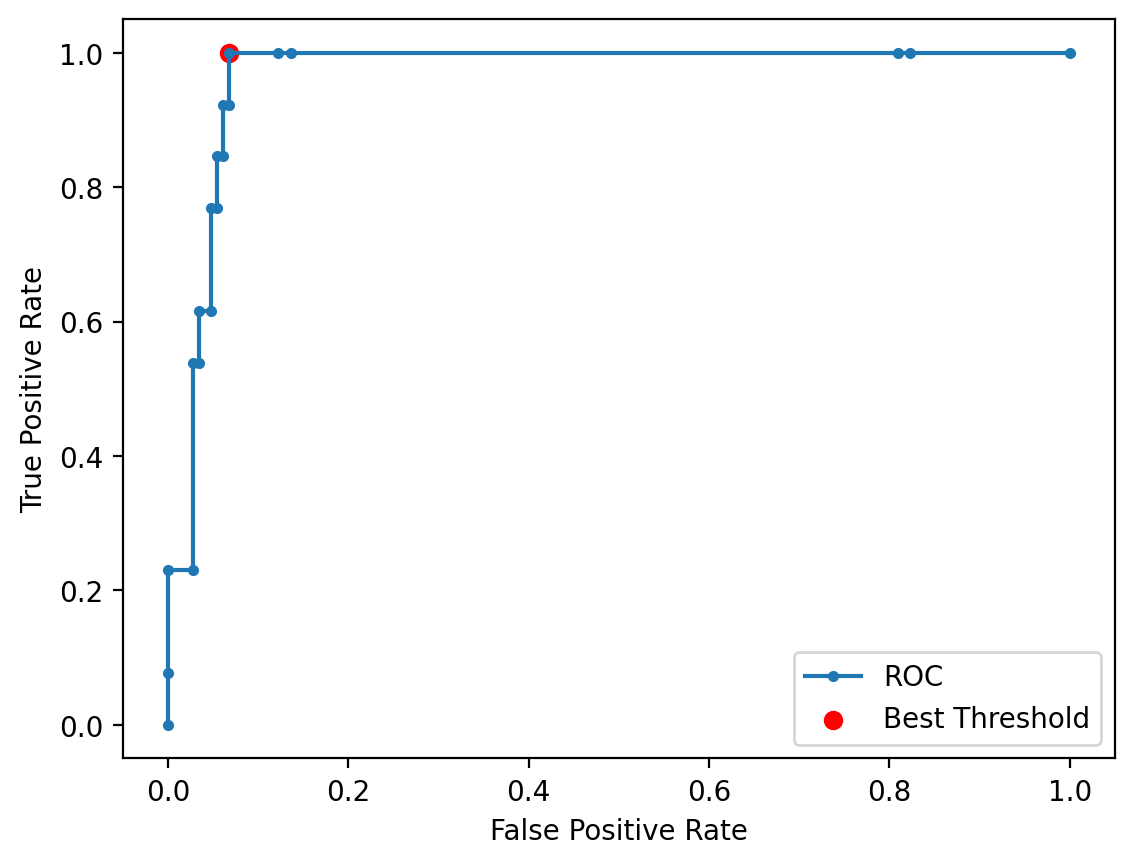

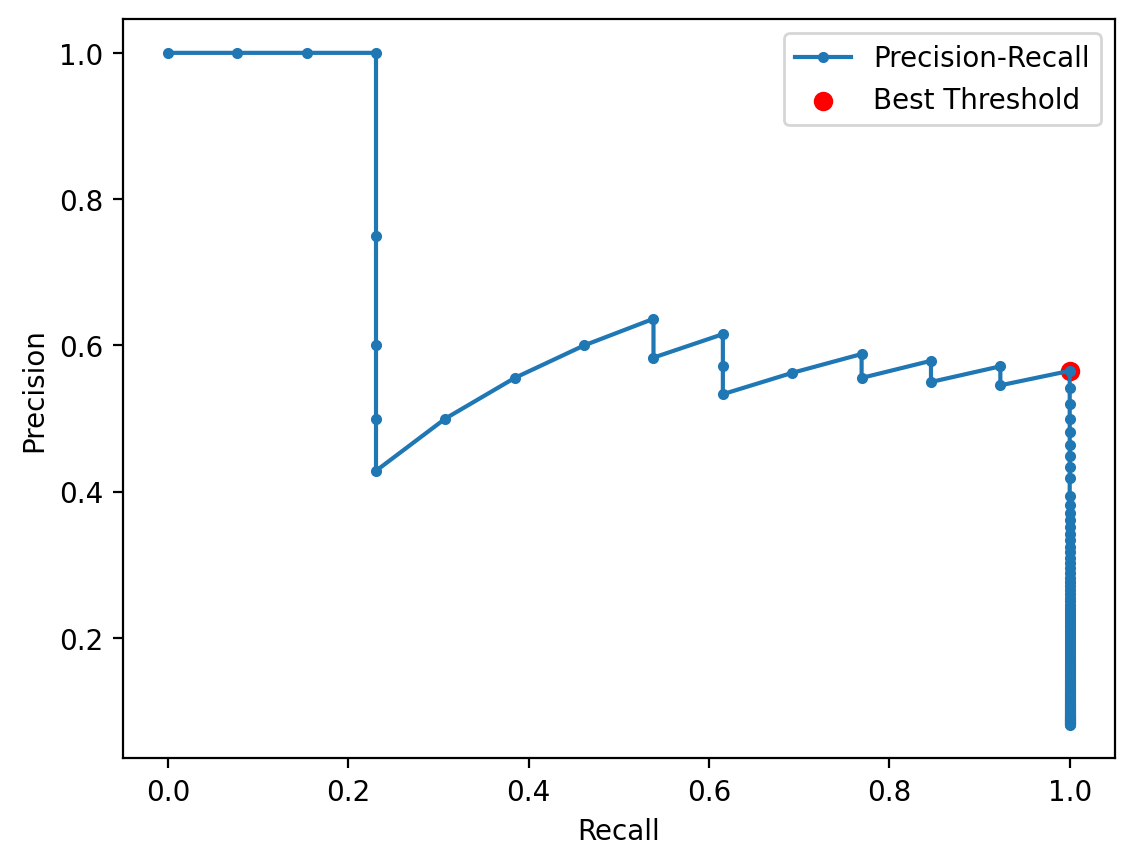

In [500]:
# 최적의 임계값 찾기
from sklearn.metrics import roc_curve, precision_recall_curve

# 모델 예측 (예: model.predict(x_val))
# ravel() 메소드 : predict 메소드가 리턴하는 다차원 배열을 1차원 배열로 변환
y_pred_prob = model.predict(test_data).ravel()

# ROC 곡선으로 최적의 임계값 찾기
fpr, tpr, thresholds_roc = roc_curve(test_targets, y_pred_prob)
gmeans = np.sqrt(tpr * (1-fpr))
ix_roc = np.argmax(gmeans)
best_threshold_roc = thresholds_roc[ix_roc]
print('Best Threshold (ROC): %.3f' % (best_threshold_roc))

# Precision-Recall 곡선으로 최적의 임계값 찾기
precision, recall, thresholds_pr = precision_recall_curve(test_targets, y_pred_prob)
fscore = (2 * precision * recall) / (precision + recall)
ix_pr = np.argmax(fscore)
best_threshold_pr = thresholds_pr[ix_pr]
print('Best Threshold (PR): %.3f' % (best_threshold_pr))

# ROC 곡선 및 최적의 임계값 시각화
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.scatter(fpr[ix_roc], tpr[ix_roc], marker='o', color='red', label='Best Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall 곡선 및 최적의 임계값 시각화
plt.plot(recall, precision, marker='.', label='Precision-Recall')
plt.scatter(recall[ix_pr], precision[ix_pr], marker='o', color='red', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [501]:
# 예측값(sigmoid 함수에 의해 출력된 확률값)을 최적의 임계값 기준으로 이진화
thresholds = 0.127
# thresholds = 0.200

binary_pred = (test_pred >= thresholds).astype(int)
print(len(binary_pred))
print(binary_pred)

160
[[1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]]


In [502]:
# 혼동 행렬 출력
from sklearn.metrics import confusion_matrix

confusion_matrix(test_targets, binary_pred)

array([[137,  10],
       [  0,  13]], dtype=int64)

In [503]:
# classification_report 출력
from sklearn.metrics import classification_report

print(classification_report(test_targets, binary_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       147
           1       0.57      1.00      0.72        13

    accuracy                           0.94       160
   macro avg       0.78      0.97      0.84       160
weighted avg       0.96      0.94      0.95       160



## 비교 모델 훈련 및 검증

In [504]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 38 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      800 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
 13  Gen1        800 non-null    bool  
 14  Gen2        800 non-null    bool  
 15  Gen3        800 non-null    bool  
 16  Gen4        800 non-null    bool  
 17  Gen5        800 non-null    bool  
 18  Gen6        800 non-null    bool  
 19  Fairy       800 non-null    bool  
 20  Dark      

In [505]:
types

['Fairy',
 'Dark',
 'Electric',
 'Normal',
 'Ice',
 'Water',
 'Ground',
 'Dragon',
 'Rock',
 'Fire',
 'Grass',
 'None',
 'Bug',
 'Ghost',
 'Fighting',
 'Poison',
 'Psychic',
 'Flying',
 'Steel']

### 특성간 상관관계 분석하기

In [506]:
# 숫자 특성만 추출한 데이터프레임
numeric_df = pokemon.drop(['Name', 'Type 1', 'Type 2'], axis=1)

# 상관행렬 계산
corr_matrix = numeric_df.corr()

# 상관행렬 출력
print(corr_matrix)

                   #     Total        HP    Attack   Defense   Sp. Atk  \
#           1.000000  0.119813  0.097614  0.102298  0.094786  0.088759   
Total       0.119813  1.000000  0.618748  0.736211  0.612787  0.747250   
HP          0.097614  0.618748  1.000000  0.422386  0.239622  0.362380   
Attack      0.102298  0.736211  0.422386  1.000000  0.438687  0.396362   
Defense     0.094786  0.612787  0.239622  0.438687  1.000000  0.223549   
Sp. Atk     0.088759  0.747250  0.362380  0.396362  0.223549  1.000000   
Sp. Def     0.085817  0.717609  0.378718  0.263990  0.510747  0.506121   
Speed       0.010733  0.575943  0.175952  0.381240  0.015227  0.473018   
Generation  0.982516  0.048384  0.058683  0.051451  0.042419  0.036437   
Legendary   0.153396  0.501758  0.273620  0.345408  0.246377  0.448907   
Gen1       -0.705300 -0.035379 -0.068967 -0.037271 -0.048947 -0.015659   
Gen2       -0.301316 -0.054829  0.029846 -0.084013 -0.005715 -0.082182   
Gen3       -0.098084  0.004681 -0.0531

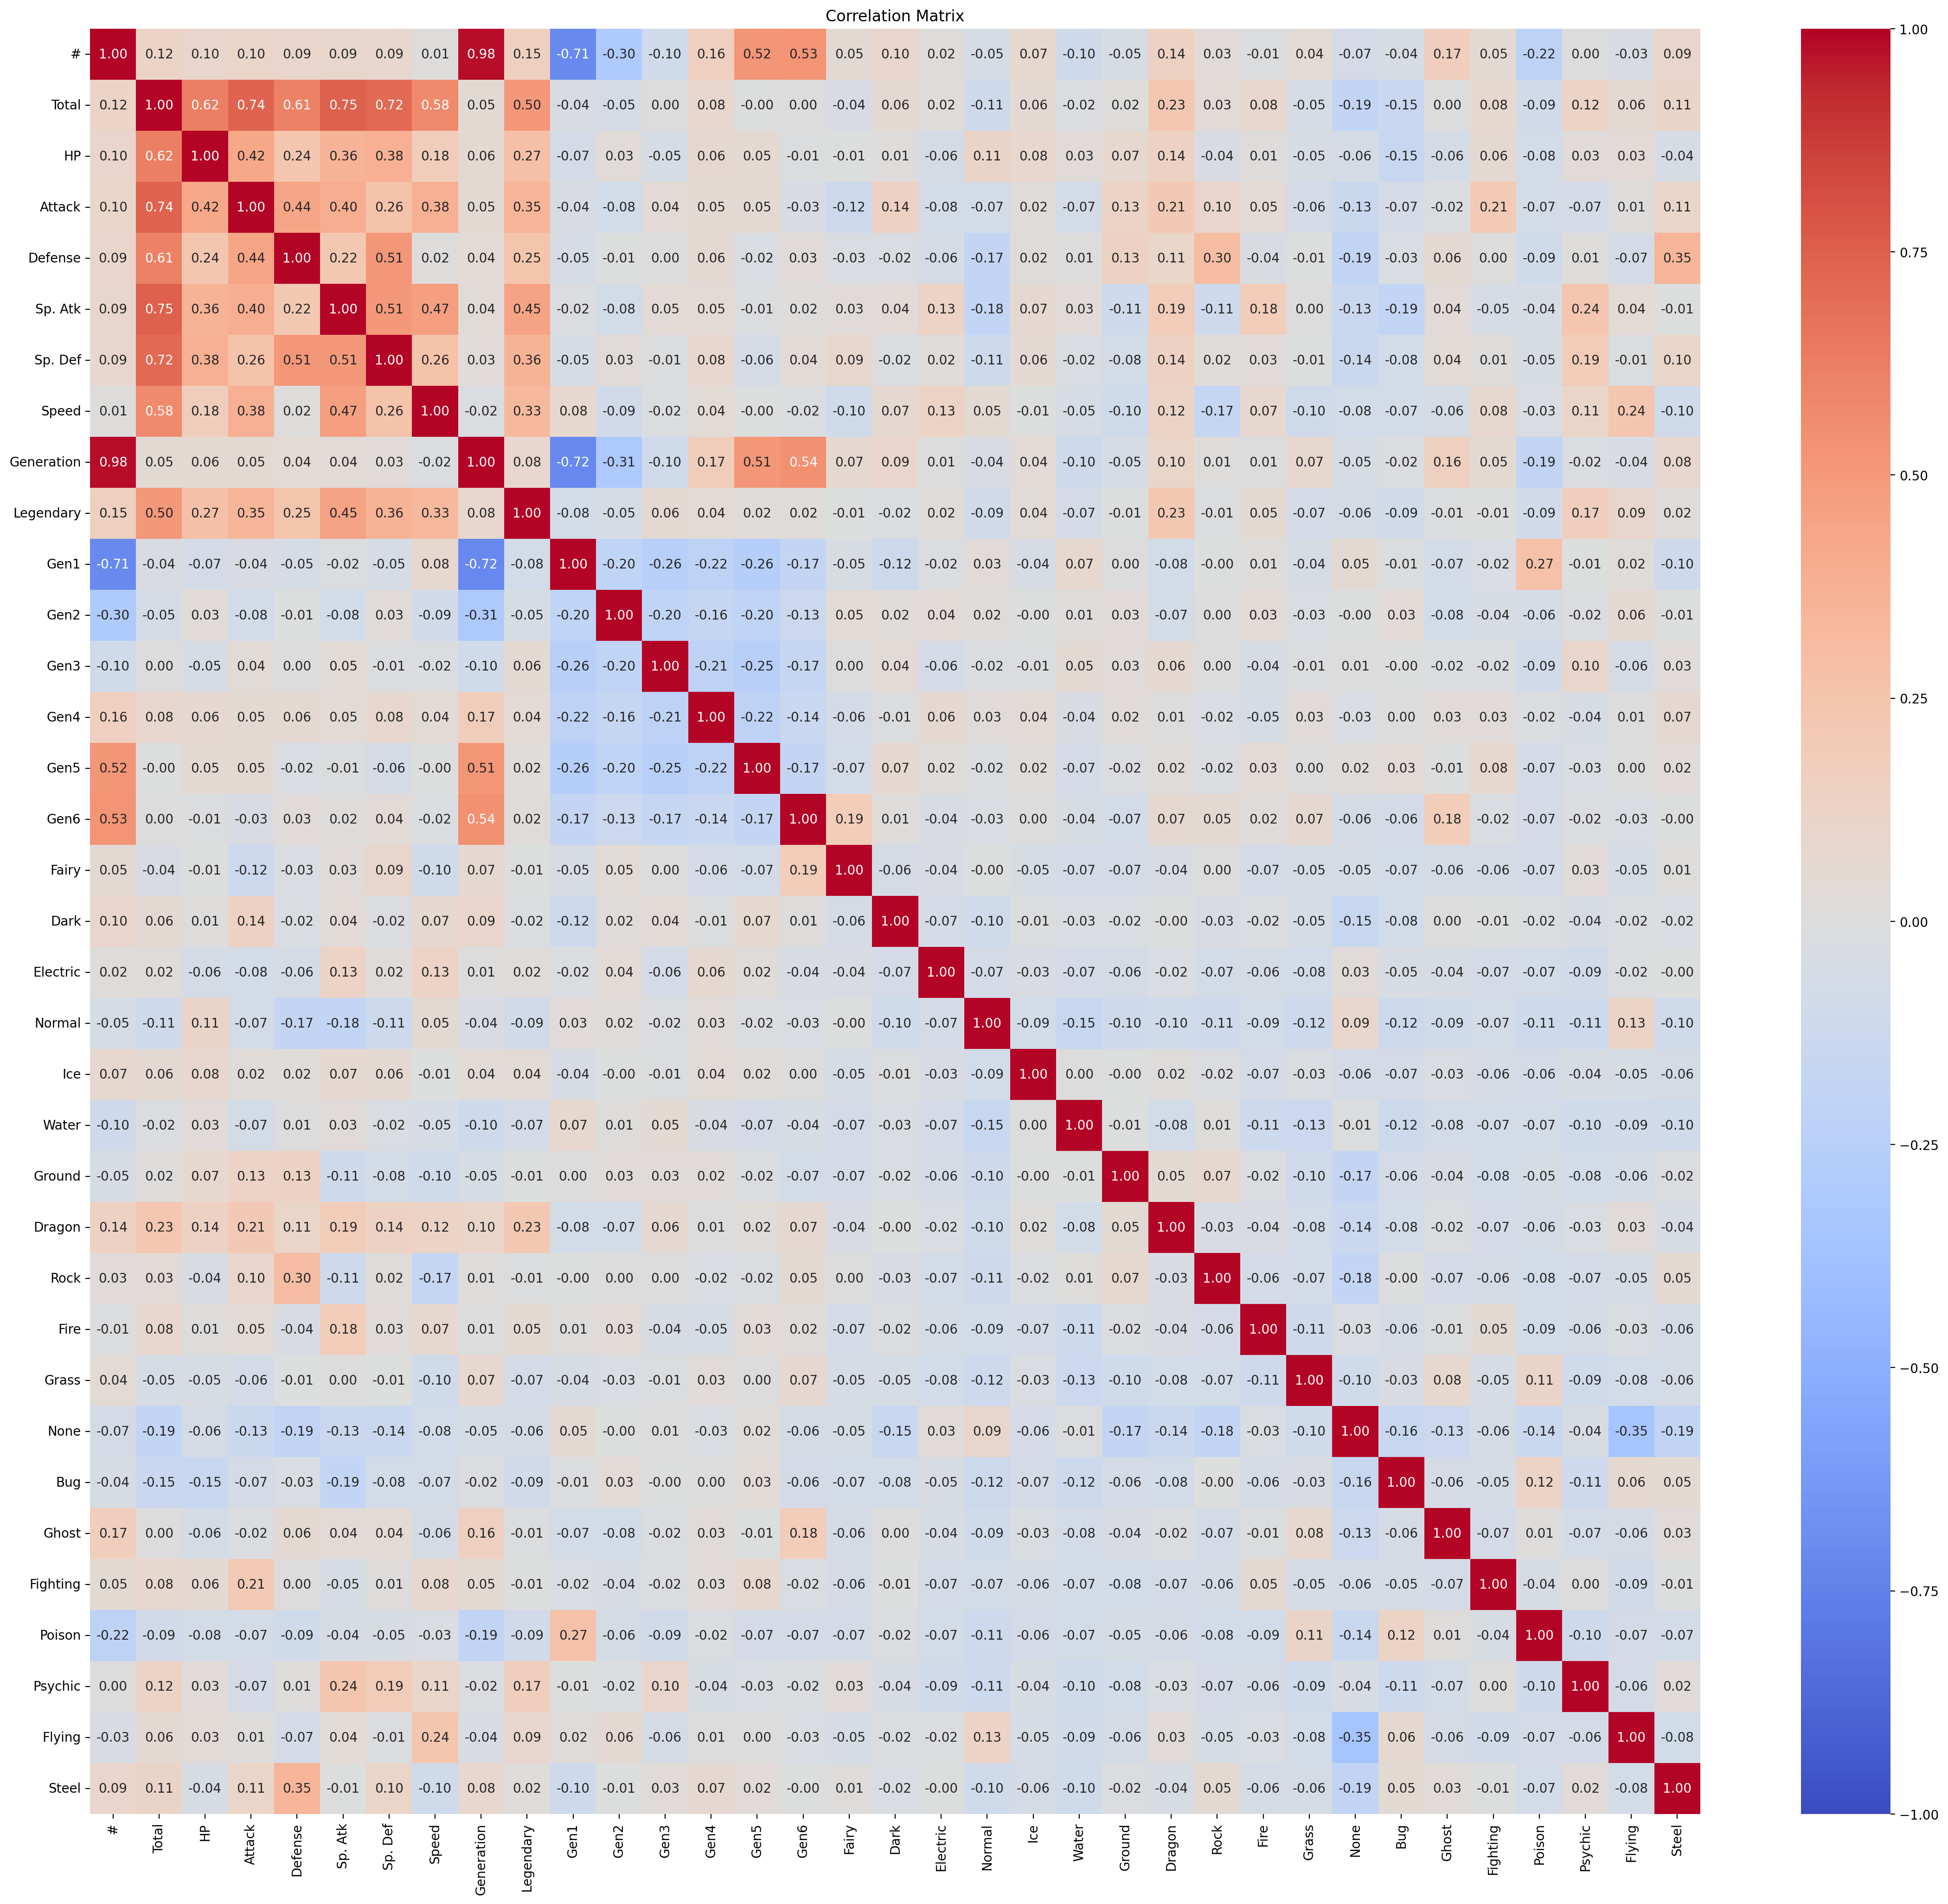

In [511]:
# 히트맵 시각화
plt.figure(figsize=(28, 25))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [512]:
# Generation 특성 제외
# [시도] 상관관계 높은 특성만 선택하는 '특성 선택' 시도해 봄. --> 비교 모델에서 추가로 추출한 특성들의 상관관계가 현저히 떨어져 사실 '특성 선택'을 하는 것이 별로 의미가 없음. (베이스라인 모델과 다를게 없으므로)
features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed',
            'Gen1' , 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6',
            'Poison', 'Ghost', 'Steel', 'Fire', 'Electric', 'Ground', 'None', 'Water', 'Normal', 'Rock',
            'Flying', 'Ice', 'Fairy', 'Fighting', 'Dragon', 'Psychic', 'Dark', 'Grass', 'Bug']

target = "Legendary"

In [513]:
pokemon = pokemon.replace({True:1, False:0})
pokemon

C:\Users\freen\AppData\Local\Temp\ipykernel_20168\1768643596.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pokemon = pokemon.replace({True:1, False:0})


#                   Name   Type 1  Type 2  Total  HP  Attack  Defense  \
0      1              Bulbasaur    Grass  Poison    318  45      49       49   
1      2                Ivysaur    Grass  Poison    405  60      62       63   
2      3               Venusaur    Grass  Poison    525  80      82       83   
3      3  VenusaurMega Venusaur    Grass  Poison    625  80     100      123   
4      4             Charmander     Fire    None    309  39      52       43   
..   ...                    ...      ...     ...    ...  ..     ...      ...   
795  719                Diancie     Rock   Fairy    600  50     100      150   
796  719    DiancieMega Diancie     Rock   Fairy    700  50     160      110   
797  720    HoopaHoopa Confined  Psychic   Ghost    600  80     110       60   
798  720     HoopaHoopa Unbound  Psychic    Dark    680  80     160       60   
799  721              Volcanion     Fire   Water    600  80     110      120   

     Sp. Atk  Sp. Def  ...  Fire  Grass  None  Bug  Ghost  Fighting  Poison  \
0         65       65  ...     0      1     0    0      0         0       1   
1         80       80  ...     0      1     0    0      0         0       1   
2        100      100  ...     0      1     0    0      0         0       1   
3        122      120  ...     0      1     0    0      0         0       1   
4         60       50  ...     1      0     1    0      0         0       0   
..       ...      ...  ...   ...    ...   ...  ...    ...       ...     ...   
795      100      150  ...     0      0     0    0      0         0       0   
796      160      110  ...     0      0     0    0      0         0       0   
797      150      130  ...     0      0     0    0      1         0       0   
798      170      130  ...     0      0     0    0      0         0       0   
799      130       90  ...     1      0     0    0      0         0       0   

     Psychic  Flying  Steel  
0          0       0      0  
1          0       0      0  
2          0       0      0  
3          0       0      0  
4          0       0      0  
..       ...     ...    ...  
795        0       0      0  
796        0       0      0  
797        1       0      0  
798        1       0      0  
799        0       0      0  

[800 rows x 38 columns]

In [514]:
X = pokemon[features]
print(X.shape)
X.head()

(800, 32)


Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Gen1  Gen2  Gen3  ...  \
0    318  45      49       49       65       65     45     1     0     0  ...   
1    405  60      62       63       80       80     60     1     0     0  ...   
2    525  80      82       83      100      100     80     1     0     0  ...   
3    625  80     100      123      122      120     80     1     0     0  ...   
4    309  39      52       43       60       50     65     1     0     0  ...   

   Rock  Flying  Ice  Fairy  Fighting  Dragon  Psychic  Dark  Grass  Bug  
0     0       0    0      0         0       0        0     0      1    0  
1     0       0    0      0         0       0        0     0      1    0  
2     0       0    0      0         0       0        0     0      1    0  
3     0       0    0      0         0       0        0     0      1    0  
4     0       0    0      0         0       0        0     0      0    0  

[5 rows x 32 columns]

In [515]:
y = pokemon[target]
print(y.shape)
y.head()

(800,)


0    0
1    0
2    0
3    0
4    0
Name: Legendary, dtype: int64

In [516]:
# 훈련 데이터셋과 테스트 데이터셋 분리
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=15)

print(train_data.shape, train_targets.shape)
print(test_data.shape, test_targets.shape)

(640, 32) (640,)
(160, 32) (160,)


### 데이터 정규화하기

In [517]:
# 정규화 대상 컬럼만 추출하기
# ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']
sub_train_data = train_data[['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']]
sub_test_data = test_data[['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']]

In [518]:
sub_train_data

Total   HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
300    430   60      85       60       50       50    125
351    500  170      90       45       90       45     60
193    280   55      40       40       65       45     35
794    600  108     100      121       81       95     95
798    680   80     160       60      170      130     80
..     ...  ...     ...      ...      ...      ...    ...
156    580   90      85      100       95      125     85
384    440   60      90       70       60      120     40
645    535   71      95       85      110       95     79
757    482   86      92       88       68       75     73
456    495   60      52      168       47      138     30

[640 rows x 7 columns]

In [519]:
sub_test_data

Total   HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
270    680  106     130       90      110      154     90
475    480   65      76       84       54       96    105
158    580   90     100       90      125       85     90
247    500   75      90       50      110       80     95
452    515   60      70       65      125      105     90
..     ...  ...     ...      ...      ...      ...    ...
719    405   61      78       95       56       58     57
548    600  100     100      100      100      100    100
618    325   50      65       85       35       35     55
785    494   55      85      122       58       75     99
41     483   95      70       73       95       90     60

[160 rows x 7 columns]

In [520]:
# 정규화 : 평균을 빼고 표준편차로 나누기 -> 평균이 0, 표준편차가 1인 정규분포로 만들어짐.
# [중요] 각 특성별로 정규화해야 함.
# axis=0 의 의미 : 첫번째 축(즉, 샘플축)의 개수를 사용해 평균과 표준편차를 계산한다는 의미임. 즉, 샘플 개수로 나누겠다는 의미.
mean = sub_train_data.mean(axis=0)
sub_train_data -= mean
std = sub_train_data.std(axis=0)
sub_train_data /= std

# [중요] 테스트 데이터셋에 대해서 정규화 할 때에도 앞에서 훈련 데이터셋에서 계산한 평균값과 표준편차값을 그대로 재사용해서 정규화해야 함!
sub_test_data -= mean
sub_test_data /= std

In [521]:
sub_train_data

Total        HP    Attack   Defense   Sp. Atk   Sp. Def     Speed
300 -0.051796 -0.357560  0.182272 -0.445624 -0.692950 -0.795553  1.922531
351  0.537902  3.886616  0.337067 -0.931539  0.515546 -0.972921 -0.295118
193 -1.315435 -0.550477 -1.210888 -1.093511 -0.239764 -0.972921 -1.148060
794  1.380328  1.494444  0.646658  1.530429  0.243635  0.800763  0.899001
798  2.054269  0.414109  2.504205 -0.445624  2.932538  2.042342  0.387236
..        ...       ...       ...       ...       ...       ...       ...
156  1.211843  0.799943  0.182272  0.850148  0.666608  1.864974  0.557824
384  0.032447 -0.357560  0.337067 -0.121681 -0.390826  1.687606 -0.977471
645  0.832751  0.066858  0.491863  0.364234  1.119794  0.800763  0.353118
757  0.386266  0.645609  0.398986  0.461417 -0.149126  0.091289  0.148412
456  0.495781 -0.357560 -0.839379  3.052962 -0.783587  2.326132 -1.318648

[640 rows x 7 columns]

In [522]:
sub_test_data

Total        HP    Attack   Defense   Sp. Atk   Sp. Def     Speed
270  2.054269  1.417277  1.575432  0.526205  1.119794  2.893711  0.728412
475  0.369417 -0.164643 -0.096360  0.331839 -0.572100  0.836237  1.240178
158  1.211843  0.799943  0.646658  0.526205  1.572980  0.446026  0.728412
247  0.537902  0.221191  0.337067 -0.769568  1.119794  0.268658  0.899001
452  0.664266 -0.357560 -0.282115 -0.283653  1.572980  1.155500  0.728412
..        ...       ...       ...       ...       ...       ...       ...
719 -0.262403 -0.318976 -0.034442  0.688177 -0.511675 -0.511763 -0.397471
548  1.380328  1.185777  0.646658  0.850148  0.817670  0.978132  1.069589
618 -0.936344 -0.743394 -0.436910  0.364234 -1.146136 -1.327658 -0.465706
785  0.487357 -0.550477  0.182272  1.562824 -0.451250  0.091289  1.035471
41   0.394690  0.992860 -0.282115 -0.024498  0.666608  0.623395 -0.295118

[160 rows x 7 columns]

In [523]:
sub2_train_data = train_data.drop(['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed'], axis=1)
sub2_test_data = test_data.drop(['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed'], axis=1)

In [524]:
sub2_train_data

Gen1  Gen2  Gen3  Gen4  Gen5  Gen6  Poison  Ghost  Steel  Fire  ...  \
300     0     0     1     0     0     0       0      0      0     0  ...   
351     0     0     1     0     0     0       0      0      0     0  ...   
193     0     1     0     0     0     0       0      0      0     0  ...   
794     0     0     0     0     0     1       0      0      0     0  ...   
798     0     0     0     0     0     1       0      0      0     0  ...   
..    ...   ...   ...   ...   ...   ...     ...    ...    ...   ...  ...   
156     1     0     0     0     0     0       0      0      0     0  ...   
384     0     0     1     0     0     0       0      0      0     0  ...   
645     0     0     0     0     1     0       0      0      0     0  ...   
757     0     0     0     0     0     1       0      0      0     0  ...   
456     0     0     0     1     0     0       0      0      1     0  ...   

     Rock  Flying  Ice  Fairy  Fighting  Dragon  Psychic  Dark  Grass  Bug  
300     0       1    0      0         0       0        0     0      0    0  
351     0       0    0      0         0       0        0     0      0    0  
193     0       0    0      0         0       0        0     0      0    0  
794     0       0    0      0         0       1        0     0      0    0  
798     0       0    0      0         0       0        1     1      0    0  
..    ...     ...  ...    ...       ...     ...      ...   ...    ...  ...  
156     0       1    1      0         0       0        0     0      0    0  
384     0       0    0      0         0       0        0     0      0    0  
645     0       0    1      0         0       0        0     0      0    0  
757     0       0    0      0         0       0        1     1      0    0  
456     1       0    0      0         0       0        0     0      0    0  

[640 rows x 25 columns]

In [525]:
sub2_test_data

Gen1  Gen2  Gen3  Gen4  Gen5  Gen6  Poison  Ghost  Steel  Fire  ...  \
270     0     1     0     0     0     0       0      0      0     1  ...   
475     0     0     0     1     0     0       0      0      0     0  ...   
158     1     0     0     0     0     0       0      0      0     1  ...   
247     0     1     0     0     0     0       0      0      0     1  ...   
452     0     0     0     1     0     0       1      0      0     0  ...   
..    ...   ...   ...   ...   ...   ...     ...    ...    ...   ...  ...   
719     0     0     0     0     0     1       0      0      0     0  ...   
548     0     0     0     1     0     0       0      0      0     0  ...   
618     0     0     0     0     1     0       0      0      0     0  ...   
785     0     0     0     0     0     1       0      1      0     0  ...   
41      1     0     0     0     0     0       0      0      0     0  ...   

     Rock  Flying  Ice  Fairy  Fighting  Dragon  Psychic  Dark  Grass  Bug  
270     0       1    0      0         0       0        0     0      0    0  
475     0       0    0      0         0       0        0     0      0    0  
158     0       1    0      0         0       0        0     0      0    0  
247     0       0    0      0         0       0        0     1      0    0  
452     0       0    0      0         0       0        0     0      1    0  
..    ...     ...  ...    ...       ...     ...      ...   ...    ...  ...  
719     0       0    0      0         0       0        0     0      1    0  
548     0       0    0      0         0       0        0     0      0    0  
618     1       0    0      0         0       0        0     0      0    1  
785     0       0    0      0         0       0        0     0      1    0  
41      0       0    0      1         0       0        0     0      0    0  

[160 rows x 25 columns]

In [526]:
# 데이터 프레임 합치기
train_data = pd.concat([sub_train_data, sub2_train_data], axis=1)
test_data = pd.concat([sub_test_data, sub2_test_data], axis=1)

In [527]:
train_data

Total        HP    Attack   Defense   Sp. Atk   Sp. Def     Speed  \
300 -0.051796 -0.357560  0.182272 -0.445624 -0.692950 -0.795553  1.922531   
351  0.537902  3.886616  0.337067 -0.931539  0.515546 -0.972921 -0.295118   
193 -1.315435 -0.550477 -1.210888 -1.093511 -0.239764 -0.972921 -1.148060   
794  1.380328  1.494444  0.646658  1.530429  0.243635  0.800763  0.899001   
798  2.054269  0.414109  2.504205 -0.445624  2.932538  2.042342  0.387236   
..        ...       ...       ...       ...       ...       ...       ...   
156  1.211843  0.799943  0.182272  0.850148  0.666608  1.864974  0.557824   
384  0.032447 -0.357560  0.337067 -0.121681 -0.390826  1.687606 -0.977471   
645  0.832751  0.066858  0.491863  0.364234  1.119794  0.800763  0.353118   
757  0.386266  0.645609  0.398986  0.461417 -0.149126  0.091289  0.148412   
456  0.495781 -0.357560 -0.839379  3.052962 -0.783587  2.326132 -1.318648   

     Gen1  Gen2  Gen3  ...  Rock  Flying  Ice  Fairy  Fighting  Dragon  \
300     0     0     1  ...     0       1    0      0         0       0   
351     0     0     1  ...     0       0    0      0         0       0   
193     0     1     0  ...     0       0    0      0         0       0   
794     0     0     0  ...     0       0    0      0         0       1   
798     0     0     0  ...     0       0    0      0         0       0   
..    ...   ...   ...  ...   ...     ...  ...    ...       ...     ...   
156     1     0     0  ...     0       1    1      0         0       0   
384     0     0     1  ...     0       0    0      0         0       0   
645     0     0     0  ...     0       0    1      0         0       0   
757     0     0     0  ...     0       0    0      0         0       0   
456     0     0     0  ...     1       0    0      0         0       0   

     Psychic  Dark  Grass  Bug  
300        0     0      0    0  
351        0     0      0    0  
193        0     0      0    0  
794        0     0      0    0  
798        1     1      0    0  
..       ...   ...    ...  ...  
156        0     0      0    0  
384        0     0      0    0  
645        0     0      0    0  
757        1     1      0    0  
456        0     0      0    0  

[640 rows x 32 columns]

In [528]:
test_data

Total        HP    Attack   Defense   Sp. Atk   Sp. Def     Speed  \
270  2.054269  1.417277  1.575432  0.526205  1.119794  2.893711  0.728412   
475  0.369417 -0.164643 -0.096360  0.331839 -0.572100  0.836237  1.240178   
158  1.211843  0.799943  0.646658  0.526205  1.572980  0.446026  0.728412   
247  0.537902  0.221191  0.337067 -0.769568  1.119794  0.268658  0.899001   
452  0.664266 -0.357560 -0.282115 -0.283653  1.572980  1.155500  0.728412   
..        ...       ...       ...       ...       ...       ...       ...   
719 -0.262403 -0.318976 -0.034442  0.688177 -0.511675 -0.511763 -0.397471   
548  1.380328  1.185777  0.646658  0.850148  0.817670  0.978132  1.069589   
618 -0.936344 -0.743394 -0.436910  0.364234 -1.146136 -1.327658 -0.465706   
785  0.487357 -0.550477  0.182272  1.562824 -0.451250  0.091289  1.035471   
41   0.394690  0.992860 -0.282115 -0.024498  0.666608  0.623395 -0.295118   

     Gen1  Gen2  Gen3  ...  Rock  Flying  Ice  Fairy  Fighting  Dragon  \
270     0     1     0  ...     0       1    0      0         0       0   
475     0     0     0  ...     0       0    0      0         0       0   
158     1     0     0  ...     0       1    0      0         0       0   
247     0     1     0  ...     0       0    0      0         0       0   
452     0     0     0  ...     0       0    0      0         0       0   
..    ...   ...   ...  ...   ...     ...  ...    ...       ...     ...   
719     0     0     0  ...     0       0    0      0         0       0   
548     0     0     0  ...     0       0    0      0         0       0   
618     0     0     0  ...     1       0    0      0         0       0   
785     0     0     0  ...     0       0    0      0         0       0   
41      1     0     0  ...     0       0    0      1         0       0   

     Psychic  Dark  Grass  Bug  
270        0     0      0    0  
475        0     0      0    0  
158        0     0      0    0  
247        0     1      0    0  
452        0     0      1    0  
..       ...   ...    ...  ...  
719        0     0      1    0  
548        0     0      0    0  
618        0     0      0    1  
785        0     0      1    0  
41         0     0      0    0  

[160 rows x 32 columns]

In [529]:
# Numpy 배열 형태로 변환
train_data = np.array(train_data)
train_targets = np.array(train_targets)
test_data = np.array(test_data)
test_targets = np.array(test_targets)

In [530]:
train_data

array([[-0.05179605, -0.35755976,  0.18227177, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53790227,  3.88661609,  0.33706733, ...,  0.        ,
         0.        ,  0.        ],
       [-1.31543528, -0.55047684, -1.21088826, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.83275142,  0.06685783,  0.49186289, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38626556,  0.64560908,  0.39898555, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.49578096, -0.35755976, -0.83937892, ...,  0.        ,
         0.        ,  0.        ]])

In [531]:
train_targets

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [532]:
test_data

array([[ 2.05426935,  1.41727742,  1.5754318 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36941703, -0.16464267, -0.09636024, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.21184319,  0.79994275,  0.64665845, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.93634351, -0.74339393, -0.43691046, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.4873567 , -0.55047684,  0.18227177, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.39468982,  0.99285983, -0.28211491, ...,  0.        ,
         0.        ,  0.        ]])

In [533]:
test_targets

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

### K-겹 교차 검증 진행

In [534]:
# K-겹 교차 검증에 사용할 기본 모델 정의, 컴파일
# [시도] 가중치 규제 또는 드롭다운을 추가함 --> 훈련시켜보니 너무 매끄러워지면서 오히려 과적합 시점이 거의 드러나지 않음. 
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras import regularizers

def build_model():
    model = keras.Sequential([
        # layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
        layers.Dense(16, activation="relu"),
        # layers.Dropout(0.2),
        # layers.Dense(8, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
        layers.Dense(8, activation="relu"),
        # layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    # model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["AUC"])
    return model

In [535]:
# K-겹 교차 검증 진행
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100

all_loss_histories = []
all_val_loss_histories = []
# all_acc_histories = []
all_auc_histories = []
all_val_auc_histories = []

for i in range(k):
    print(f"#{i}번째 폴드 처리중")

    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    # [확인용] 지정한 평가지표에 따른 History 객체가 포함하고 있는 key 이름 출력
    print(history.history.keys())

    # loss_history = history.history["val_loss"]
    # acc_history = history.history["val_accuracy"]
    # all_loss_histories.append(loss_history)
    # all_acc_histories.append(acc_history)

    loss_history = history.history["loss"]
    val_loss_history = history.history["val_loss"]
    auc_history = history.history["AUC"]
    val_auc_history = history.history["val_AUC"]

    all_loss_histories.append(loss_history)
    all_val_loss_histories.append(val_loss_history)
    all_auc_histories.append(auc_history)
    all_val_auc_histories.append(val_auc_history)      

#0번째 폴드 처리중
dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])
#1번째 폴드 처리중
dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])
#2번째 폴드 처리중
dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])
#3번째 폴드 처리중
dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


In [536]:
# 정확도 평균값 계산하기
# average_acc_history = [
#     np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]

# AUC 평균값 계산하기
average_auc_history = [
    np.mean([x[i] for x in all_auc_histories]) for i in range(num_epochs)]

average_val_auc_history = [
    np.mean([x[i] for x in all_val_auc_histories]) for i in range(num_epochs)]

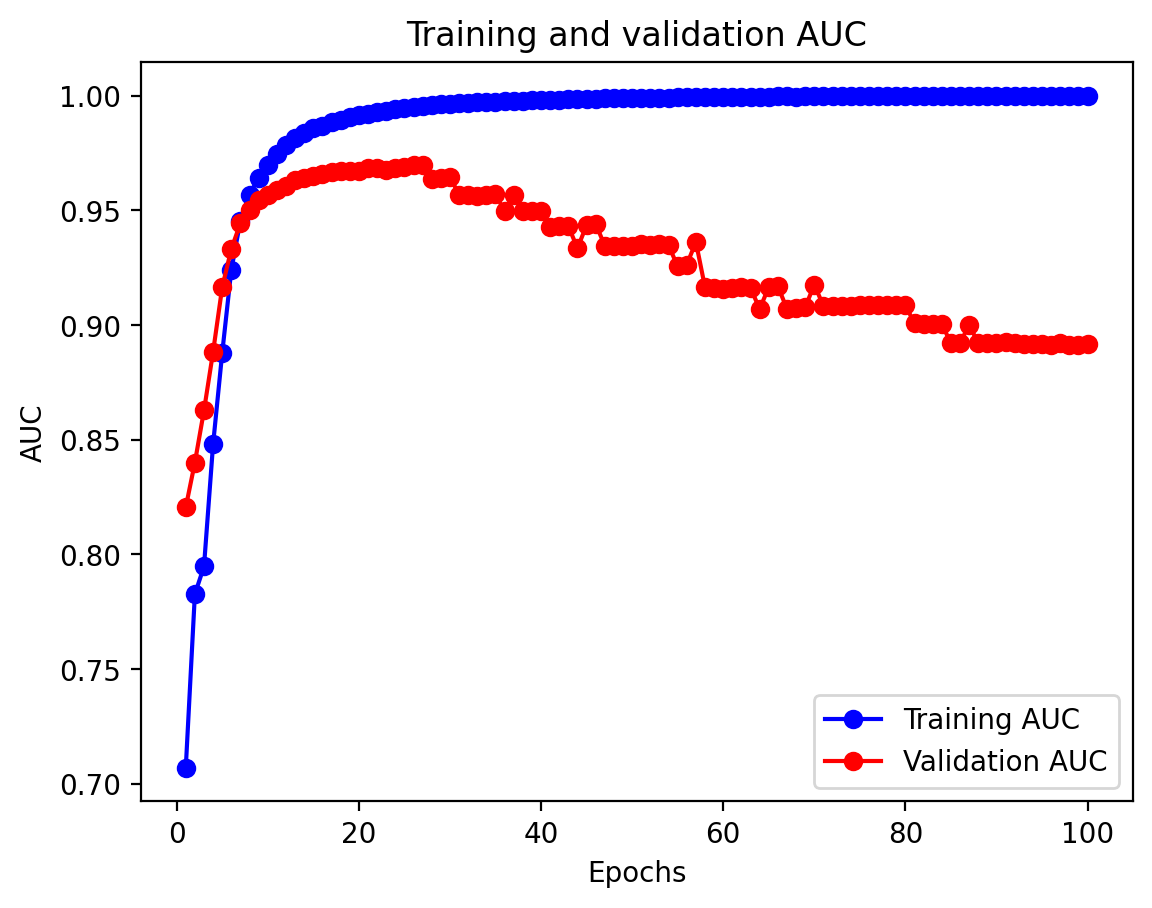

In [537]:
# AUC 값 그래프로 표시하기
epochs = range(1, len(average_auc_history) + 1)
plt.plot(epochs, average_auc_history, "bo-", label="Training AUC")
plt.plot(epochs, average_val_auc_history, "ro-", label="Validation AUC")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

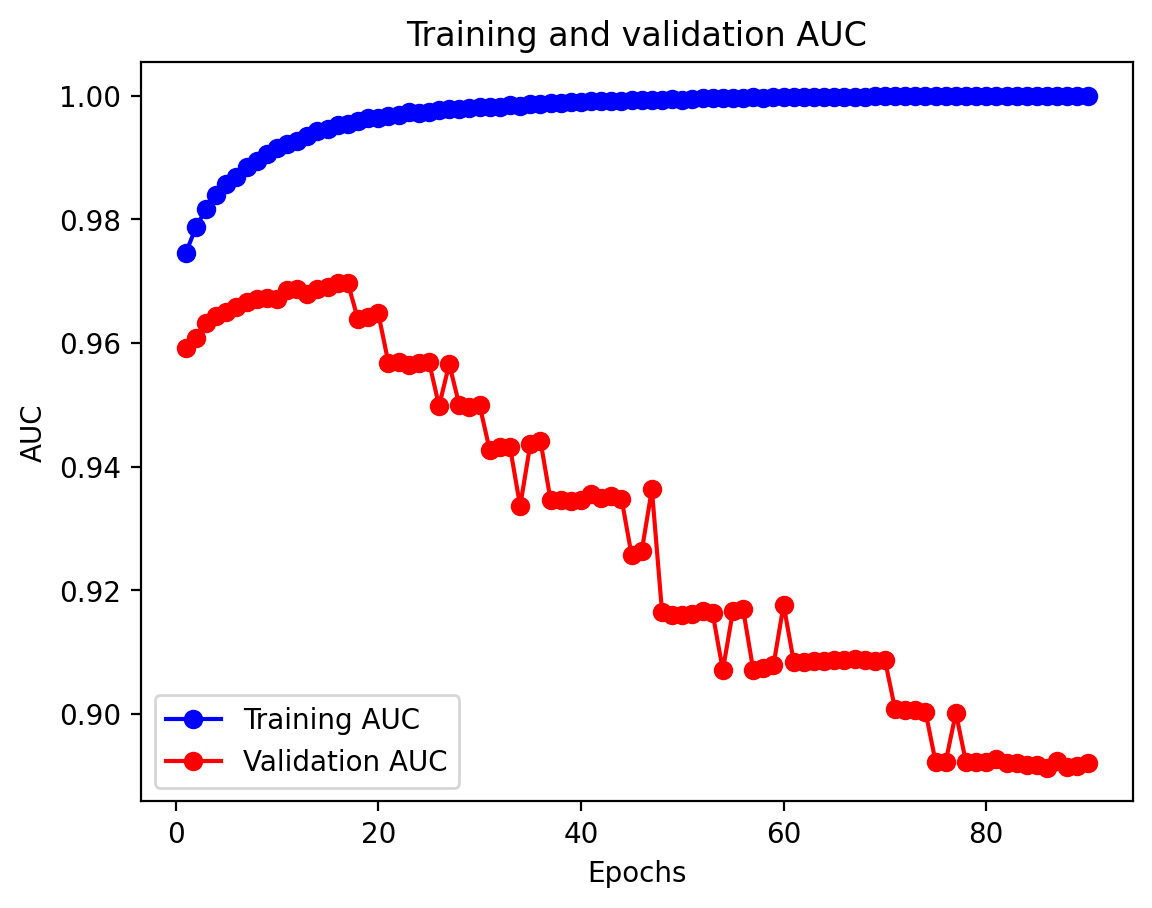

In [538]:
truncated_auc_history = average_auc_history[10:]
truncated_val_auc_history = average_val_auc_history[10:]
epochs = range(1, len(truncated_auc_history) + 1)

plt.plot(epochs, truncated_auc_history, "bo-", label="Training AUC")
plt.plot(epochs, truncated_val_auc_history, "ro-", label="Validation AUC")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [539]:
# 손실값 평균값 계산하기
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]

average_val_loss_history = [
    np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]

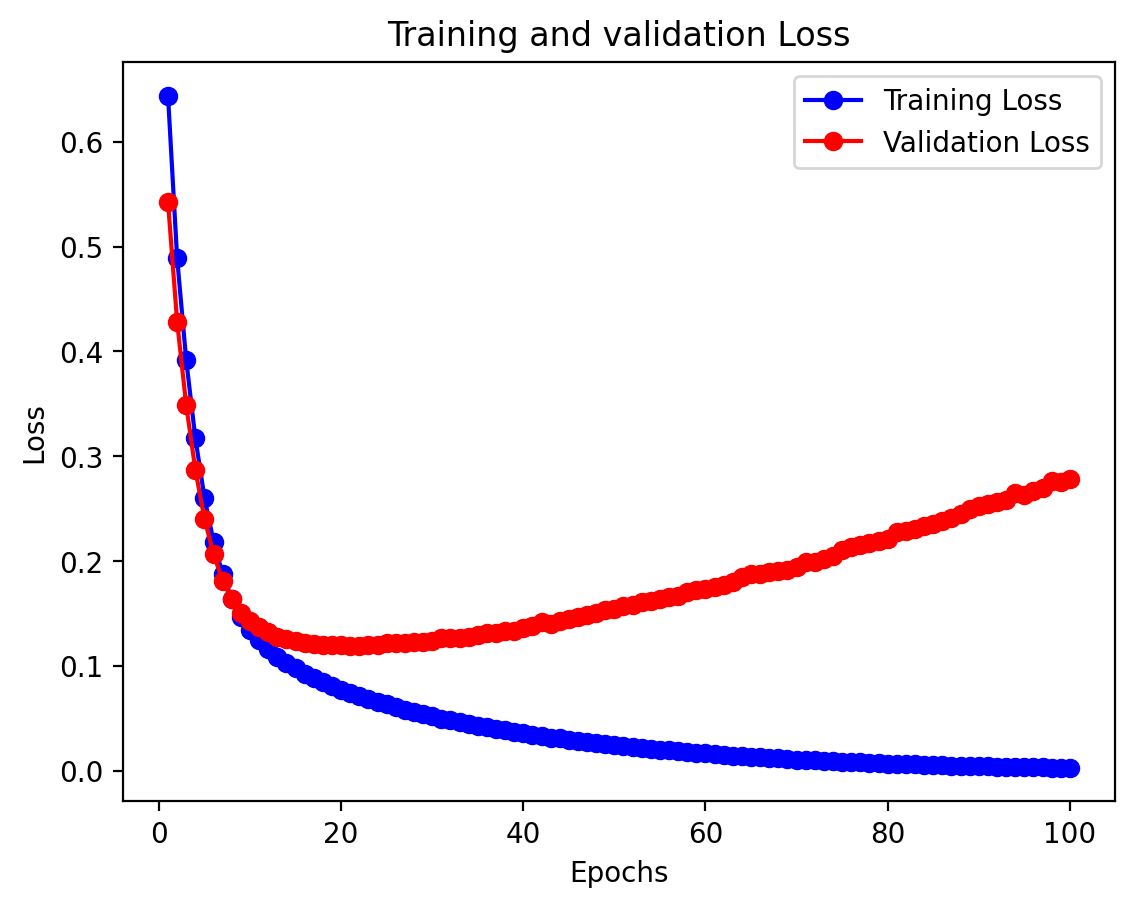

In [540]:
# loss 값 그래프로 표시하기
epochs = range(1, len(average_loss_history) + 1)
plt.plot(epochs, average_loss_history, "bo-", label="Training Loss")
plt.plot(epochs, average_val_loss_history, "ro-", label="Validation Loss")
plt.title("Training and validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

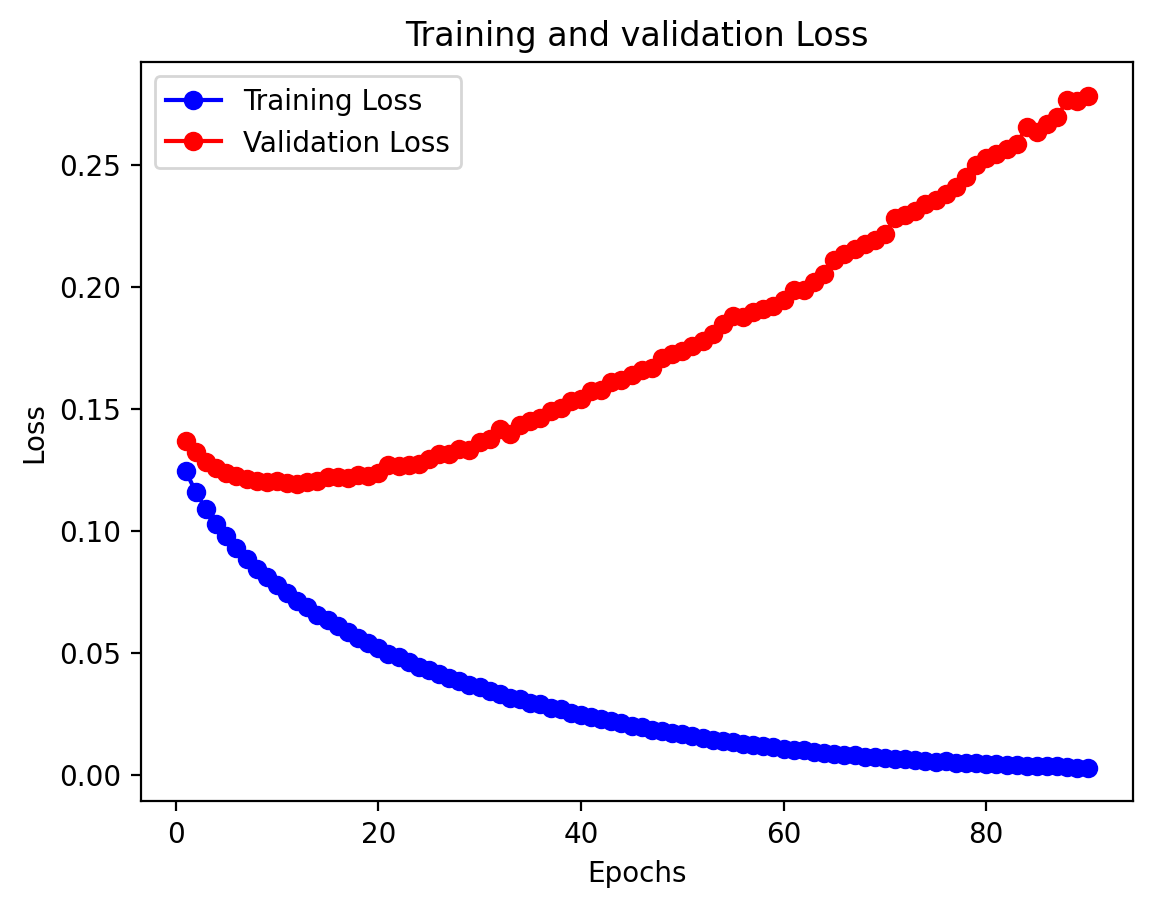

In [541]:
truncated_loss_history = average_loss_history[10:]
truncated_val_loss_history = average_val_loss_history[10:]
epochs = range(1, len(truncated_loss_history) + 1)

plt.plot(epochs, truncated_loss_history, "bo-", label="Training Loss")
plt.plot(epochs, truncated_val_loss_history, "ro-", label="Validation Loss")
plt.title("Training and validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [542]:
pd.Series(average_val_auc_history)[:60]

0     0.820575
1     0.840087
2     0.862776
3     0.888359
4     0.916498
5     0.933199
6     0.944499
7     0.950210
8     0.954737
9     0.956762
10    0.959112
11    0.960820
12    0.963225
13    0.964373
14    0.964942
15    0.965859
16    0.966618
17    0.967120
18    0.967250
19    0.967094
20    0.968513
21    0.968725
22    0.967865
23    0.968745
24    0.969122
25    0.969629
26    0.969657
27    0.963816
28    0.964168
29    0.964793
30    0.956762
31    0.956877
32    0.956485
33    0.956735
34    0.956985
35    0.949797
36    0.956600
37    0.949936
38    0.949587
39    0.949885
40    0.942638
41    0.943235
42    0.943127
43    0.933583
44    0.943594
45    0.944171
46    0.934590
47    0.934529
48    0.934460
49    0.934521
50    0.935497
51    0.934841
52    0.935224
53    0.934822
54    0.925643
55    0.926363
56    0.936292
57    0.916502
58    0.916011
59    0.915946
dtype: float64

In [543]:
pd.Series(average_val_loss_history)[:60]

0     0.542401
1     0.428347
2     0.348609
3     0.287224
4     0.240611
5     0.206591
6     0.181518
7     0.163553
8     0.151086
9     0.142931
10    0.136882
11    0.132322
12    0.128105
13    0.125771
14    0.123910
15    0.122375
16    0.121291
17    0.120341
18    0.119867
19    0.120536
20    0.119445
21    0.119117
22    0.120220
23    0.120305
24    0.121986
25    0.122085
26    0.121599
27    0.123054
28    0.122667
29    0.123756
30    0.126857
31    0.126414
32    0.127064
33    0.127569
34    0.129482
35    0.131374
36    0.131628
37    0.133373
38    0.133198
39    0.136342
40    0.137783
41    0.141886
42    0.139731
43    0.143411
44    0.145094
45    0.146428
46    0.149032
47    0.150517
48    0.153394
49    0.154157
50    0.157198
51    0.157904
52    0.161038
53    0.161600
54    0.163853
55    0.165921
56    0.166727
57    0.170622
58    0.172447
59    0.173769
dtype: float64

### 최종 모델 훈련하기

In [544]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=22, batch_size=16, verbose=0)
# test_loss_score, test_acc_score = model.evaluate(test_data, test_targets)
test_loss_score, test_auc_score = model.evaluate(test_data, test_targets)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9817 - loss: 0.1033  


In [545]:
test_loss_score, test_auc_score

(0.11622700840234756, 0.9738357067108154)

### 혼동 행렬과 classification_report 출력하기

In [546]:
test_pred = model.predict(test_data)
print(len(test_pred))
test_pred

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
160


array([[8.55883241e-01],
       [2.01376202e-03],
       [2.26605684e-01],
       [2.42817728e-03],
       [4.14954871e-03],
       [2.91533615e-05],
       [4.67386450e-08],
       [1.01304824e-04],
       [4.99408459e-10],
       [2.94181968e-09],
       [1.66146888e-03],
       [1.81759651e-06],
       [1.13893766e-05],
       [5.03780177e-12],
       [1.55883299e-06],
       [1.19756319e-01],
       [1.73653586e-06],
       [7.91613698e-01],
       [4.86579491e-04],
       [2.85927876e-04],
       [5.01884222e-01],
       [1.41741077e-10],
       [1.28806064e-07],
       [2.15759665e-05],
       [2.31028721e-07],
       [9.28377813e-06],
       [1.13145390e-03],
       [1.07486255e-06],
       [4.08011923e-11],
       [5.39188795e-06],
       [8.31488252e-01],
       [9.86246974e-04],
       [3.96584452e-04],
       [2.20518956e-07],
       [1.14819274e-08],
       [1.46861908e-06],
       [6.88057298e-07],
       [2.75383098e-03],
       [4.27219084e-06],
       [5.05727826e-07],


In [547]:
for i in range(100):
  print(test_targets[i], test_pred[i])

1 [0.85588324]
0 [0.00201376]
1 [0.22660568]
0 [0.00242818]
0 [0.00414955]
0 [2.9153362e-05]
0 [4.6738645e-08]
0 [0.0001013]
0 [4.9940846e-10]
0 [2.9418197e-09]
0 [0.00166147]
0 [1.8175965e-06]
0 [1.1389377e-05]
0 [5.0378018e-12]
0 [1.558833e-06]
0 [0.11975632]
0 [1.7365359e-06]
1 [0.7916137]
0 [0.00048658]
0 [0.00028593]
1 [0.5018842]
0 [1.4174108e-10]
0 [1.2880606e-07]
0 [2.1575966e-05]
0 [2.3102872e-07]
0 [9.283778e-06]
0 [0.00113145]
0 [1.0748626e-06]
0 [4.0801192e-11]
0 [5.391888e-06]
1 [0.83148825]
0 [0.00098625]
0 [0.00039658]
0 [2.2051896e-07]
0 [1.1481927e-08]
0 [1.4686191e-06]
0 [6.880573e-07]
0 [0.00275383]
0 [4.272191e-06]
0 [5.057278e-07]
0 [8.961465e-08]
0 [2.1800178e-08]
0 [2.0269871e-08]
0 [0.00116433]
0 [0.00471897]
0 [3.4980607e-07]
0 [5.860165e-06]
0 [0.00021798]
0 [0.9323764]
0 [0.00031348]
0 [5.149166e-07]
0 [2.762523e-10]
0 [0.02808347]
0 [3.721012e-05]
0 [8.408437e-07]
0 [0.00011487]
0 [0.18548025]
0 [1.7639679e-05]
0 [2.6388829e-05]
0 [1.4310167e-07]
0 [0.079231

In [548]:
# 예측값(sigmoid 함수에 의해 출력된 확률값)을 0.5 기준으로 이진화
thresholds = 0.5

binary_pred = (test_pred >= thresholds).astype(int)
print(len(binary_pred))
binary_pred

160


array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [549]:
# 혼동 행렬 출력
from sklearn.metrics import confusion_matrix

confusion_matrix(test_targets, binary_pred)

array([[144,   3],
       [  4,   9]], dtype=int64)

In [550]:
# classification_report 출력
from sklearn.metrics import classification_report

print(classification_report(test_targets, binary_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       147
           1       0.75      0.69      0.72        13

    accuracy                           0.96       160
   macro avg       0.86      0.84      0.85       160
weighted avg       0.95      0.96      0.96       160



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Best Threshold (ROC): 0.117
Best Threshold (PR): 0.932


C:\Users\freen\AppData\Local\Temp\ipykernel_20168\3380611071.py:17: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


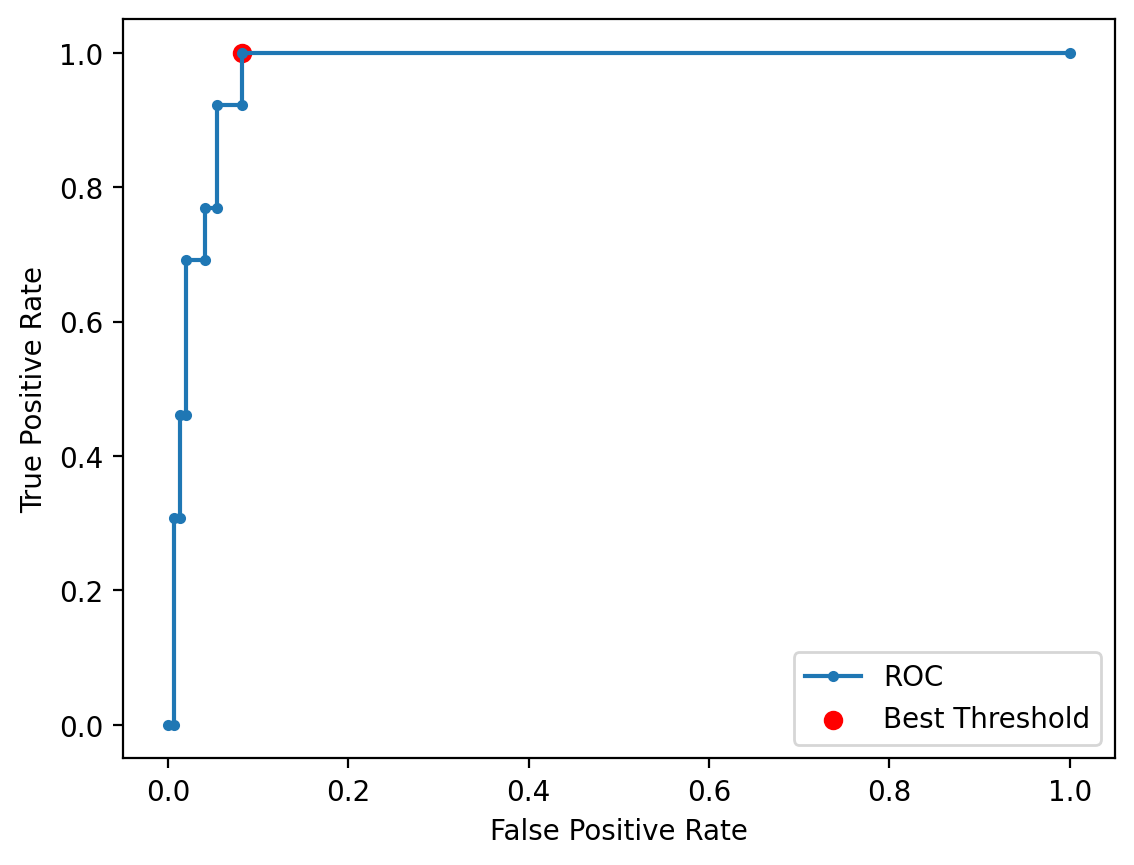

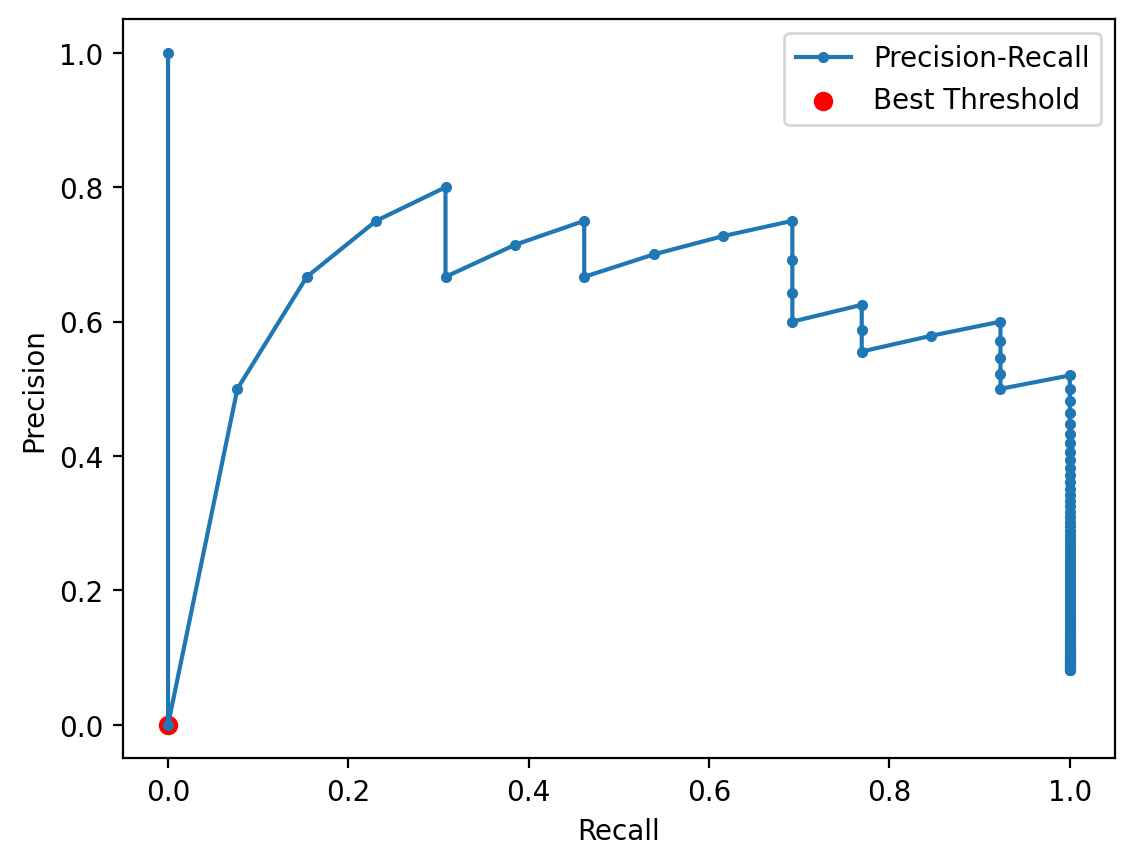

In [551]:
# 최적의 임계값 찾기
from sklearn.metrics import roc_curve, precision_recall_curve

# 모델 예측 (예: model.predict(x_val))
# ravel() 메소드 : predict 메소드가 리턴하는 다차원 배열을 1차원 배열로 변환
y_pred_prob = model.predict(test_data).ravel()

# ROC 곡선으로 최적의 임계값 찾기
fpr, tpr, thresholds_roc = roc_curve(test_targets, y_pred_prob)
gmeans = np.sqrt(tpr * (1-fpr))
ix_roc = np.argmax(gmeans)
best_threshold_roc = thresholds_roc[ix_roc]
print('Best Threshold (ROC): %.3f' % (best_threshold_roc))

# Precision-Recall 곡선으로 최적의 임계값 찾기
precision, recall, thresholds_pr = precision_recall_curve(test_targets, y_pred_prob)
fscore = (2 * precision * recall) / (precision + recall)
ix_pr = np.argmax(fscore)
best_threshold_pr = thresholds_pr[ix_pr]
print('Best Threshold (PR): %.3f' % (best_threshold_pr))

# ROC 곡선 및 최적의 임계값 시각화
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.scatter(fpr[ix_roc], tpr[ix_roc], marker='o', color='red', label='Best Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall 곡선 및 최적의 임계값 시각화
plt.plot(recall, precision, marker='.', label='Precision-Recall')
plt.scatter(recall[ix_pr], precision[ix_pr], marker='o', color='red', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [552]:
ix_roc, ix_pr

(12, 159)

In [553]:
# 예측값(sigmoid 함수에 의해 출력된 확률값)을 최적의 임계값(ROC 곡선 기준) 기준으로 이진화
thresholds = 0.117
# thresholds = 0.481

binary_pred = (test_pred >= thresholds).astype(int)
print(len(binary_pred))
binary_pred

160


array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [554]:
# 혼동 행렬 출력
from sklearn.metrics import confusion_matrix

confusion_matrix(test_targets, binary_pred)

array([[135,  12],
       [  0,  13]], dtype=int64)

In [555]:
# classification_report 출력
from sklearn.metrics import classification_report

print(classification_report(test_targets, binary_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       147
           1       0.52      1.00      0.68        13

    accuracy                           0.93       160
   macro avg       0.76      0.96      0.82       160
weighted avg       0.96      0.93      0.94       160



# STEP 4. Summary
---

- 베이스라인 모델
	- 최종 손실값 : 0.12228159606456757
	- 최종 AUC : 0.9748822450637817
	- 혼동 행렬
		- 50% 임계값<br>
			[[142,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5],<br>
			&nbsp;[&nbsp;&nbsp;3,&nbsp;&nbsp;&nbsp;&nbsp;10]]
		- 최적 입계값(ROC 곡선 기준)
			[[131,    16],
			 [  1,    12]]
			[[131,&nbsp;&nbsp;&nbsp;&nbsp;16],<br>
			&nbsp;[&nbsp;&nbsp;1,&nbsp;&nbsp;&nbsp;&nbsp;12]]
	- classification report
		- 50% 임계값
			- 정확도 : 95%
			- 일반몬 : 98%(precision), 97%(recall), 97%(f1 score)
			- 전설몬 : 67%(precision), 77%(recall), 71%(f1 score)
		- 최적 임계값(ROC 곡선 기준) 
			- 정확도 : 89% (일반몬 하나로만 찍어도 92%인 상황에서)
			- 일반몬 : 99%(precision), 89%(recall), 94%(f1 score)
			- 전설몬 : 43%(precision), 92%(recall), 59%(f1 score)
- 비교 모델
	- 최종 손실값 : 0.10449061542749405
	- 최종 AUC : 0.9767137765884399
	- 혼동 행렬
		- 50% 임계값<br>
			[[143,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4],<br>
			&nbsp;[&nbsp;&nbsp;3,&nbsp;&nbsp;&nbsp;&nbsp;10]]
		- 최적 입계값(ROC 곡선 기준)
			[[131,    16],
			 [  1,    12]]
			[[133,&nbsp;&nbsp;&nbsp;&nbsp;14],<br>
			&nbsp;[&nbsp;&nbsp;1,&nbsp;&nbsp;&nbsp;&nbsp;12]]
	- classification report
		- 50% 임계값
			- 정확도 : 96%
			- 일반몬 : 98%(precision), 97%(recall), 98%(f1 score)
			- 전설몬 : 71%(precision), 77%(recall), 74%(f1 score)
		- 최적 임계값(ROC 곡선 기준) 
			- 정확도 : 91% (일반몬 하나로만 찍어도 92%인 상황에서)
			- 일반몬 : 99%(precision), 90%(recall), 95%(f1 score)
			- 전설몬 : 46%(precision), 92%(recall), 62%(f1 score)

- **[결론]**
	- 비교 모델이 베이스라인 모델에 비해 손실값과 AUC 모두 떨어짐!
	- 혼동 행렬로 비교했을 때는 50% 임계값에서 비교 모델이 일반몬을 1개 더 맞춤. (전설몬은 10개로 동일) 최적 임계값에서도 비교 모델이 일반몬을 2개 더 맞춤. (전설몬은 12개로 동일)
	- 따라서, classification report에서의 비율 역시 비교 모델이 베이스라인 모델에 비해 약간 상승함!
	- **하지만, 두 모델간의 차이가 160개의 샘플 중에서 1-2개 더 맞추는 정도의 수준이라 비교 모델이 베이스라인 모델에 비해 차이가 생겼다고 보기에는 너무 미미한 차이임.**
	- 샘플의 개수가 더 늘어도 이러한 차이는 크게 개선되지 않을 가능성이 높은데, 그 이유는 비교 모델에서 추가로 추출한 Generation 데이터, Type 1, Type2 데이터가 사실 전설의 포켓몬을 결정짓는 특성이라고 보기에는 상관관계가 워낙 낮기 때문임. (seaborn으로 히트맵 출력해보면 확인 가능)
	- **따라서, 이 문제의 경우에는 베이스라인 모델에서 추출한 특성만으로도 충분하며, 베이스라인 모델만으로도 의사결정트리의 결과에 준하는 classification report 결과를 보여준다고 결론 내리는 것이 좀 더 타당할 것으로 생각됨.**
	- **또한, 만약 모델의 목표가 (예측 실수가 다소 있다 하더라도) 전설의 포켓몬을 거의 빠짐없이 찾아내는 것이라면, 베이스라인 모델에 최적 임계값을 사용해 예측하도록 하는 것이 적합해 보임.**

# 회고
---

- 데이터 전처리 과정에서 범주형 데이터를 원-핫 인코딩 또는 멀티-핫 인코딩 처리하는 좀 더 간단한 방법이 있을거 같음. (다음 번 작업할 때는 시도해 볼 것)
- 데이터 전처리 과정의 스텝이 전체적으로 긴 편인데, 좀 더 압축된 코드로 작성할 수 있을 것으로 예상됨.
- 데이터셋의 크기가 너무 적어 K-겹 교차 검증 방법을 시도하였지만, 좀 더 검증의 정확도를 위해 셔플링 방법까지 시도해 봐야 함.
- 전설의 포켓몬과 일반 포켓몬의 샘플 수가 현격히 차이가 나는 상태기 때문에 평가지표로 정확도 외에 recall 또는 ROC AUC 와 같은 다른 지표로도 시도해 봐야 함. --> ROC AUC를 사용해 시도 완료!
- 가중치 규제 또는 드롭다운을 적용해 볼 필요가 있음. --> 시도해 보았는데 손실 곡선이 지나치게 매끄럽게 아주 조금씩 계속 하향하는 모습을 보여 오히려 과대적합 시점을 판단할 수 없는 상태가 되었음. 
- '드문 특성으로 인한 가짜 상관관계' 문제를 해결해 보고자 베이스라인 모델, 비교 모델 모두 '특성 선택' 과정을 적용해 볼 필요가 있음. --> 시도해 보였는데 규제 기법에서와 마찬가지로 손실 곡선이 지나치게 매끄럽게 아주 조금씩 계속 하향하는 모습을 보여 오히려 과대적합 시점을 판단할 수 없는 상태가 되었음. 
- 신경망 모델 외에 다른 모델로도 비교해 보고 싶었는데 그러지 못한 부분은 아쉬움.
- 데이터 전처리 작업에서 pandas 문법을 좀 더 자유롭게 사용할 수 있어야 함을 절실히 느낌.